**Pneumonia Detection from Chest X-rays**

By: Eitan Azizov

This notebook presents a deep learning-based solution for detecting pneumonia in chest radiographs, using a two-stage pipeline that combines image-level classification and region-level detection.

**Background**

Pneumonia is a serious respiratory condition and a leading cause of death worldwide, particularly among children and the elderly. Chest X-rays are a primary diagnostic tool, but manual interpretation can be time-consuming and subject to variability between radiologists. Automated, accurate, and interpretable tools can assist clinicians in improving diagnostic speed and reliability.

**Objective**

Our goal is to develop a robust model that not only classifies chest X-rays as normal or pneumonia but also localizes pneumonia-affected regions to enhance clinical interpretability. We use the RSNA Pneumonia Detection Challenge dataset, which includes both image-level labels and bounding box annotations.

**Approach**

We implement a two-stage pipeline:

1. **Classification Stage**  
   An ensemble of three CNN architectures (DenseNet-121, VGG-16, EfficientNet-B4) is used to classify images as normal or pneumonia. The ensemble approach boosts generalization and improves robustness across varying cases.

2. **Detection Stage**  
   Images classified as pneumonia are passed to a RetinaNet detector trained to localize pneumonia regions. This detection stage is trained only on annotated positive cases for efficiency. If no bounding boxes are detected, the image is reclassified as normal.

The pipeline was trained and validated using RSNA’s evaluation criteria, which rely on a multi-threshold mean average precision (mAP) metric. It achieved a final test set mAP of **0.21464**, which would place it **24th out of ~340 participants** in the original RSNA competition — demonstrating competitive performance on a real-world clinical dataset.

**Summary**
This notebook demonstrates how combining classification and detection strategies within a unified framework can yield both **high diagnostic accuracy** and **clinically meaningful interpretability**, making it a promising approach for automated pneumonia screening in chest X-rays and can at least aid physicians in the diagnostic process.

> **NOTE**: Since RSNA never released the annotations for the 3,000-image test set, we could not use the official test set for final evaluation.  
> Therefore, we reserved 10% of the dataset as our own test set, consisting of 2,669 images.  
> Additionally, since the challenge is now closed, we can't submit our final predictions for formal evaluation.
> However, we followed the official challenge evaluation rules and simulate the evaluation process accurately.

In [ ]:
from google.colab import drive
import zipfile
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image, ImageOps
from tqdm import tqdm
import csv
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.ops import box_iou
from torchvision.utils import draw_bounding_boxes
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
import torch.nn.functional as F
%matplotlib inline

## Load Data from Drive

In [ ]:
drive.mount('/content/drive')

rsna_path = '/content/drive/MyDrive/data/pneumonia.zip'
kermany_path = '/content/drive/MyDrive/data/chest_xray.zip'
extract_path = '/content/data'
models_dir = '/content/drive/MyDrive/models/'
data_dir = '/content/data'

rsna_extract_path = os.path.join(extract_path, 'rsna')


if not os.path.exists(rsna_extract_path):
  with zipfile.ZipFile(rsna_path, 'r') as zip_ref:
    zip_ref.extractall(rsna_extract_path)
    print('RSNA Dataset extracted successfully.')
else:
  print('RSNA Dataset already extracted.')

Mounted at /content/drive
RSNA Dataset extracted successfully.


In [ ]:
kermany_extract_path = os.path.join(extract_path, 'kermany')

if not os.path.exists(kermany_extract_path):
  with zipfile.ZipFile(kermany_path, 'r') as zip_ref:
    zip_ref.extractall(kermany_extract_path)
    print('Kermany Dataset extracted successfully.')
else:
  print('Kermany Dataset already extracted.')

Kermany Dataset extracted successfully.


In [ ]:
labels_path = os.path.join(rsna_extract_path, 'train_labels.csv')
images_dir = os.path.join(rsna_extract_path, 'images')
df = pd.read_csv(labels_path)

## EDA

In [ ]:
print(f'Shape of dataset: {df.shape}')
print(f'\nColumn Names: {df.columns.tolist()}')
df.head(10)

Shape of dataset: (30227, 6)

Column Names: ['patientId', 'x', 'y', 'width', 'height', 'Target']


patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In the RSNA dataset
Each row represnts one bounding box (area of penumonia) for a patient image.

If **Target** is 0 than is are no bounding box.
the **Target** column tells us if the image has pneumonia:
* 1 = pneumonia
* 0 = normal

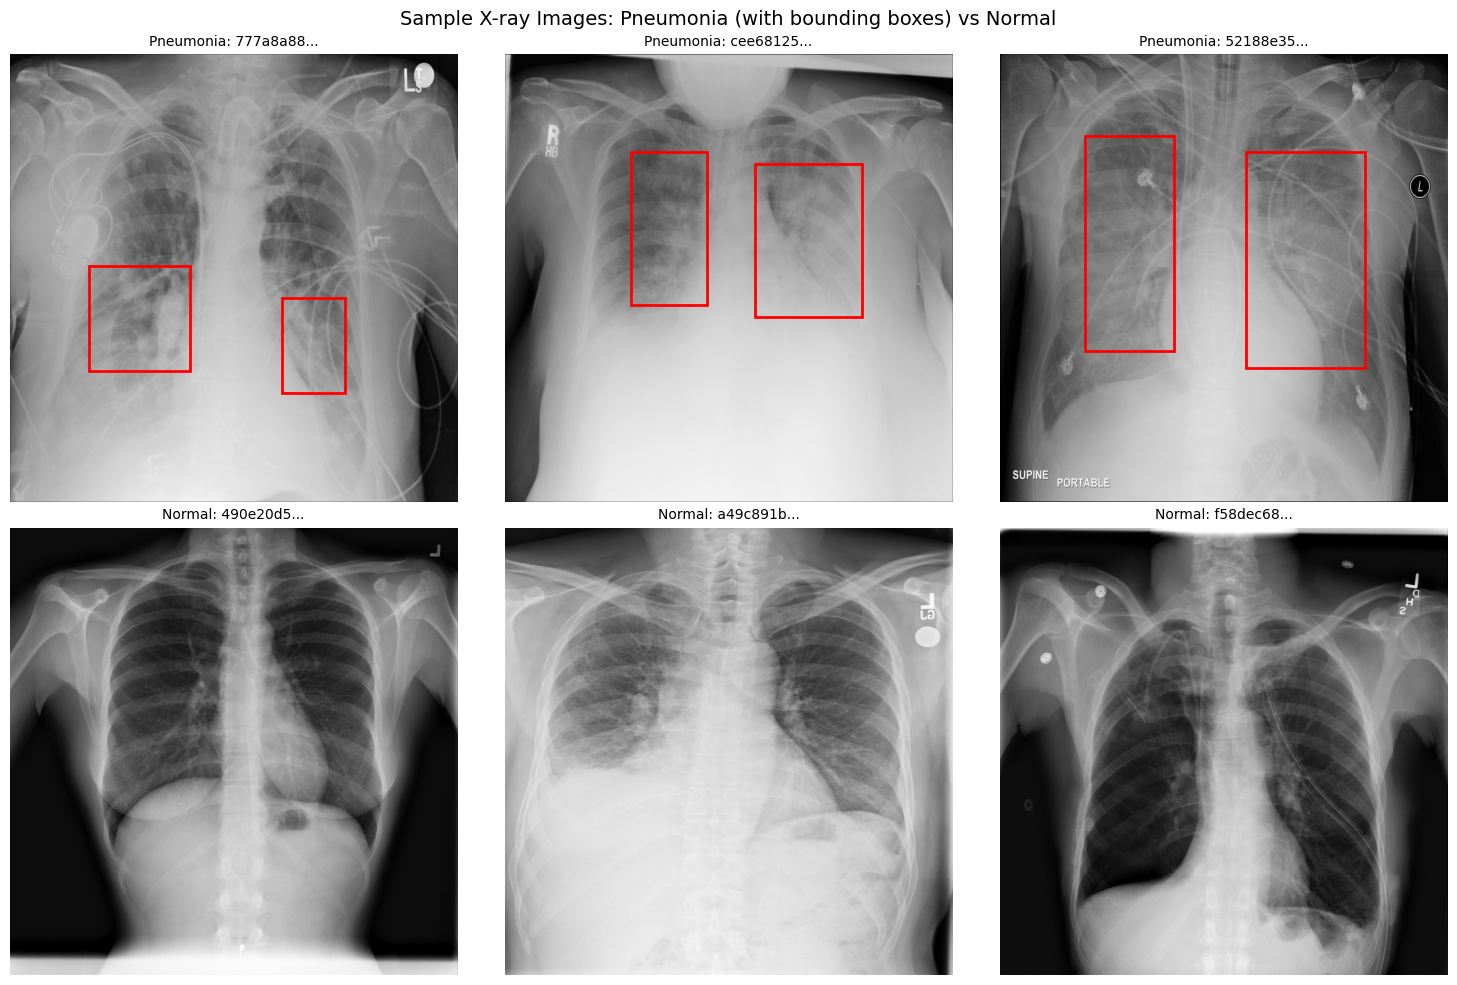

In [ ]:
# Get sample patient IDs for each class
pneumonia_patients = df[df['Target'] == 1]['patientId'].tolist()
normal_patients = df[df['Target'] == 0]['patientId'].tolist()

# Sample 3 from each class
sample_pneumonia = random.sample(pneumonia_patients, 3)
sample_normal = random.sample(normal_patients, 3)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot pneumonia cases (top row)
for i, patient_id in enumerate(sample_pneumonia):
  img_path = os.path.join(images_dir, f"{patient_id}.jpg")
  img = Image.open(img_path)

  patient_bboxes = df[df['patientId'] == patient_id]

  axes[0, i].imshow(img, cmap='gray')
  axes[0, i].set_title(f'Pneumonia: {patient_id[:8]}...', fontsize=10)
  axes[0, i].axis('off')

  for _, row in patient_bboxes.iterrows():
    rect = patches.Rectangle((row['x'], row['y']),
                              row['width'], row['height'],
                              linewidth=2, edgecolor='red', facecolor='none')
    axes[0, i].add_patch(rect)


# Plot normal cases (bottom row)
for i, patient_id in enumerate(sample_normal):
  img_path = os.path.join(images_dir, f"{patient_id}.jpg")
  img = Image.open(img_path)

  axes[1, i].imshow(img, cmap='gray')
  axes[1, i].set_title(f'Normal: {patient_id[:8]}...', fontsize=10)
  axes[1, i].axis('off')

plt.suptitle('Sample X-ray Images: Pneumonia (with bounding boxes) vs Normal', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
image_targets = df.groupby('patientId')['Target'].max()

# Count unique images by class
rsna_counts = image_targets.value_counts().rename({0: 'Normal', 1: 'Pneumonia'})
# Kermany dataset
def count_images_kermany(base_dir):
    classes = ['NORMAL', 'PNEUMONIA']
    total_counts = {'NORMAL': 0, 'PNEUMONIA': 0}
    for subset in ['train', 'val', 'test']:
        for cls in classes:
            subset_dir = os.path.join(base_dir, subset, cls)
            count = len(os.listdir(subset_dir))
            total_counts[cls] += count
    return total_counts

kermany_base = os.path.join(kermany_extract_path, 'chest_xray')
kermany_counts = count_images_kermany(kermany_base)
kermany_counts_series = pd.Series(kermany_counts).rename(index={'NORMAL': 'Normal', 'PNEUMONIA': 'Pneumonia'})

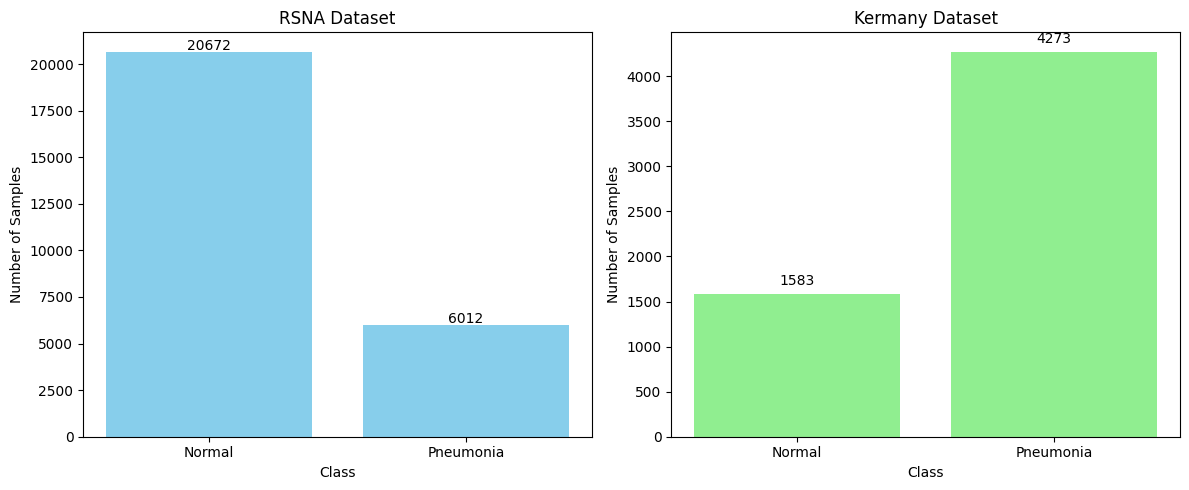

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(rsna_counts.index, rsna_counts.values, color='skyblue')
axes[0].set_title('RSNA Dataset')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xlabel('Class')
for i, v in enumerate(rsna_counts.values):
  axes[0].text(i, v+100, str(v), ha='center')

axes[1].bar(kermany_counts_series.index, kermany_counts_series.values, color='lightgreen')
axes[1].set_title('Kermany Dataset')
axes[1].set_ylabel('Number of Samples')
axes[1].set_xlabel('Class')
for i, v in enumerate(kermany_counts_series.values):
  axes[1].text(i, v+100, str(v), ha='center')

plt.tight_layout()
plt.show()

Evaluation Metric Selection:

Given the class imbalance in the dataset:

- **Normal**: 22,255 images  
- **Pneumonia**: 10,285 images

It is important to choose an evaluation metric aligned with our goal:

1. **Recall** – is preferred if the goal is to detect as many pneumonia cases as possible (minimizing false negatives), at the exapanse of increase in false positives.
2. **Precision** – Is suitable if the aim is to reduce false alarms (minimizing false positives).
3. **F1 Score** – Balances both precision and recall, providing a comprehensive measure of performance.

For this project, we chose to track and save the best models based on their **F1 score**, as it offers a balanced evaluation under class imbalance.

In [ ]:
def analyze_image_porperties(image_paths):
  widths, heights, modes = [], [], []

  for img_path in image_paths:
    try:
      with Image.open(img_path) as img:
        widths.append(img.width)
        heights.append(img.height)
        modes.append(img.mode)
    except Exeption as e:
      print(f'Error processing image {img_path}: {e}')

  return widths, heights, modes

def collect_image_paths_rsna(rsna_images_dir):
  return [
      os.path.join(rsna_images_dir, filename)
      for filename in os.listdir(rsna_images_dir)
      if filename.endswith('.jpg')
  ]

def collect_image_paths_kermany(base_dir):
  image_paths = []
  for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
      dir_path = os.path.join(base_dir, split, cls)
      image_paths.extend([
          os.path.join(dir_path, filename)
          for filename in os.listdir(dir_path)
          if filename.endswith('.jpeg')
      ])

  return image_paths

In [ ]:
from typing import Counter

def plot_image_properties(widths, heights, modes, dataset_name):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  axes[0].hist(widths, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
  axes[0].set_title(f'{dataset_name} - Image Widths')
  axes[0].set_xlabel('Width (pixels)')
  axes[0].set_ylabel('Frequency')

  axes[1].hist(heights, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
  axes[1].set_title(f'{dataset_name} - Image Heights')
  axes[1].set_xlabel('Height (pixels)')
  axes[1].set_ylabel('Frequency')

  mode_counts = Counter(modes)
  axes[2].pie(mode_counts.values(), labels=mode_counts.keys(), autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
  axes[2].set_title(f'{dataset_name} - Image Modes')

  plt.tight_layout()
  plt.show()

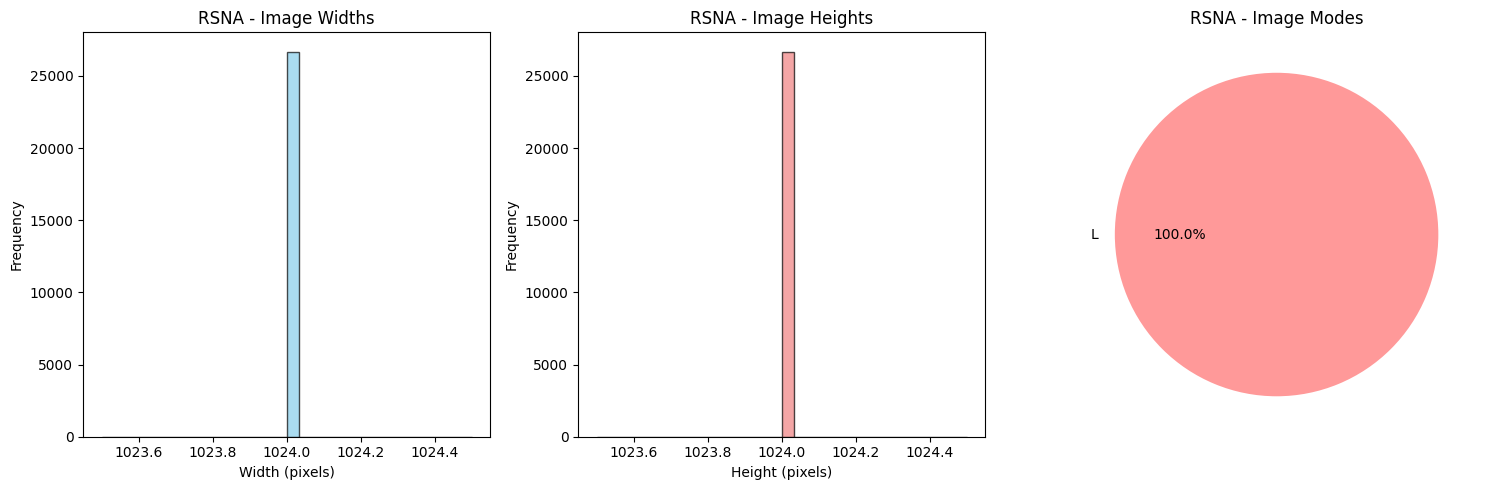

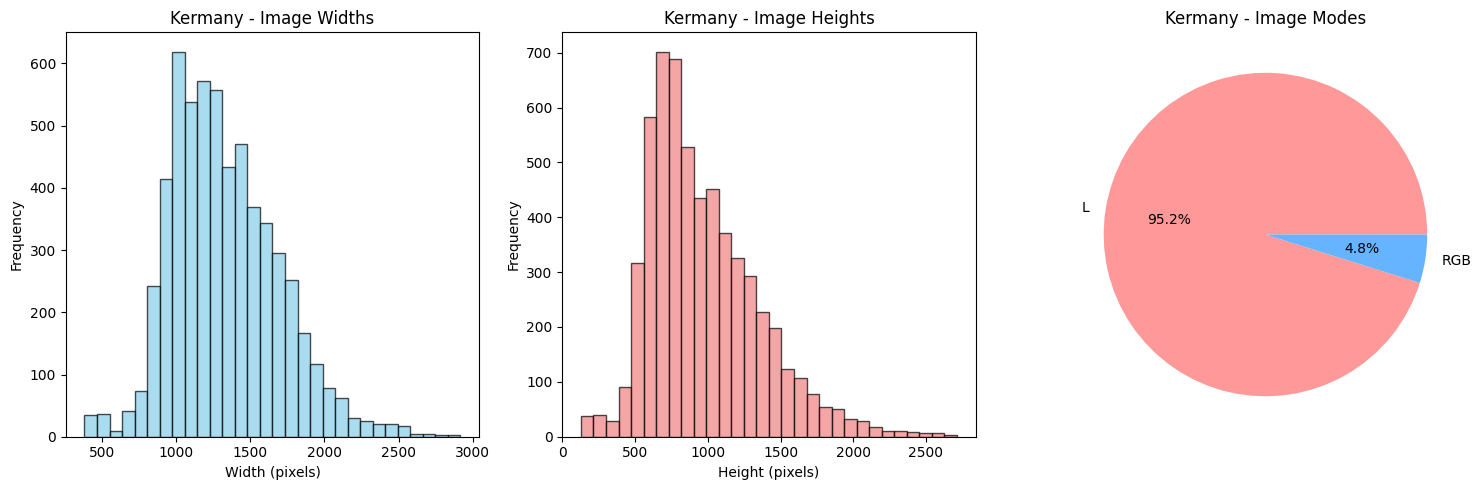

In [ ]:
rsna_images_paths = collect_image_paths_rsna(images_dir)
kermany_images_paths = collect_image_paths_kermany(kermany_base)

# RSNA Images analysis
rsna_widths, rsna_heights, rsna_modes = analyze_image_porperties(rsna_images_paths)
plot_image_properties(rsna_widths, rsna_heights, rsna_modes, 'RSNA')

# Kermany Images analysis
kermany_widths, kermany_heights, kermany_modes = analyze_image_porperties(kermany_images_paths)
plot_image_properties(kermany_widths, kermany_heights, kermany_modes, 'Kermany')

Image Size and Mode Analysis:

**RSNA Dataset:**
- All images are of size **1024×1024 pixels**
- All images are in **grayscale** mode

**Kermany Dataset:**
- Most images have a width between **1000 and 1500 pixels**
- Most images have a height between **500 and 1000 pixels**
- Approximately **95%** of the images are in **grayscale**

Due to the variation in image sizes in the Kermany dataset, we will **normalize all images to 1024×1024 pixels** to ensure consistency with the RSNA dataset.

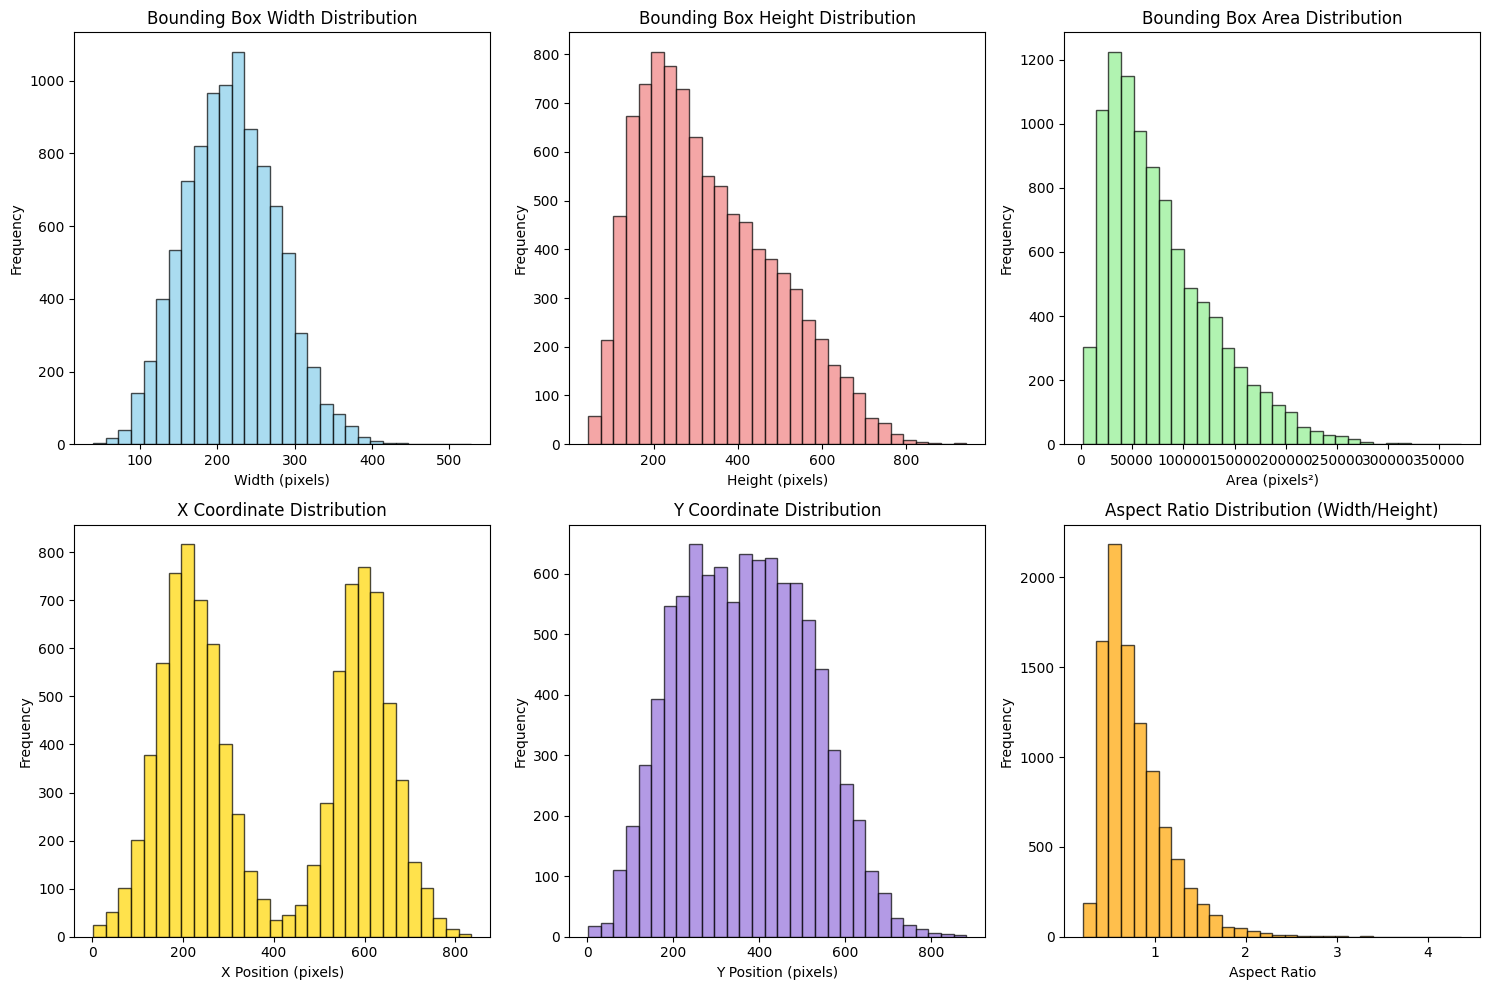

Bounding Box Statistics for Pneumonia Cases:
Width - Mean: 218.5, Std: 59.3
Height - Mean: 329.3, Std: 157.8
Area - Mean: 77523, Std: 51808
Aspect Ratio - Mean: 0.79, Std: 0.36


In [ ]:
# Filter only pneumonia cases (those with bounding boxes)
pneumonia_df = df[df['Target'] == 1].copy()

# Create visualizations for bounding box analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Bounding box width distribution
axes[0,0].hist(pneumonia_df['width'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Bounding Box Width Distribution')
axes[0,0].set_xlabel('Width (pixels)')
axes[0,0].set_ylabel('Frequency')

# 2. Bounding box height distribution
axes[0,1].hist(pneumonia_df['height'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Bounding Box Height Distribution')
axes[0,1].set_xlabel('Height (pixels)')
axes[0,1].set_ylabel('Frequency')

# 3. Bounding box area distribution
pneumonia_df['area'] = pneumonia_df['width'] * pneumonia_df['height']
axes[0,2].hist(pneumonia_df['area'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,2].set_title('Bounding Box Area Distribution')
axes[0,2].set_xlabel('Area (pixels²)')
axes[0,2].set_ylabel('Frequency')

# 4. X coordinate distribution (horizontal position)
axes[1,0].hist(pneumonia_df['x'], bins=30, alpha=0.7, color='gold', edgecolor='black')
axes[1,0].set_title('X Coordinate Distribution')
axes[1,0].set_xlabel('X Position (pixels)')
axes[1,0].set_ylabel('Frequency')

# 5. Y coordinate distribution (vertical position)
axes[1,1].hist(pneumonia_df['y'], bins=30, alpha=0.7, color='mediumpurple', edgecolor='black')
axes[1,1].set_title('Y Coordinate Distribution')
axes[1,1].set_xlabel('Y Position (pixels)')
axes[1,1].set_ylabel('Frequency')

# 6. Aspect ratio distribution
pneumonia_df['aspect_ratio'] = pneumonia_df['width'] / pneumonia_df['height']
axes[1,2].hist(pneumonia_df['aspect_ratio'], bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1,2].set_title('Aspect Ratio Distribution (Width/Height)')
axes[1,2].set_xlabel('Aspect Ratio')
axes[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Summary statistics for bounding boxes
print("Bounding Box Statistics for Pneumonia Cases:")
print(f"Width - Mean: {pneumonia_df['width'].mean():.1f}, Std: {pneumonia_df['width'].std():.1f}")
print(f"Height - Mean: {pneumonia_df['height'].mean():.1f}, Std: {pneumonia_df['height'].std():.1f}")
print(f"Area - Mean: {pneumonia_df['area'].mean():.0f}, Std: {pneumonia_df['area'].std():.0f}")
print(f"Aspect Ratio - Mean: {pneumonia_df['aspect_ratio'].mean():.2f}, Std: {pneumonia_df['aspect_ratio'].std():.2f}")

Bounding Box Statistics – RSNA Dataset:

The figure above provides an overview of bounding box characteristics in the RSNA dataset:

- **Widths** mostly range from **150 to 300 pixels**
- **Heights** are more varied, with a peak between **200 and 300 pixels**
- Most bounding boxes cover an area of **less than 100,000 pixels²**, indicating that pneumonia regions tend to be relatively small
- **X Coordinates** exhibit a **bimodal distribution**, suggesting that pneumonia often appears in **both left and right lung regions**
- **Y Coordinates** are mostly centered between **200 and 500 pixels**, indicating that infections commonly occur in the **mid to lower chest area**
- The majority of bounding boxes have an **aspect ratio between 0.5 and 1.5**, meaning they are generally **square-shaped or vertically elongated**

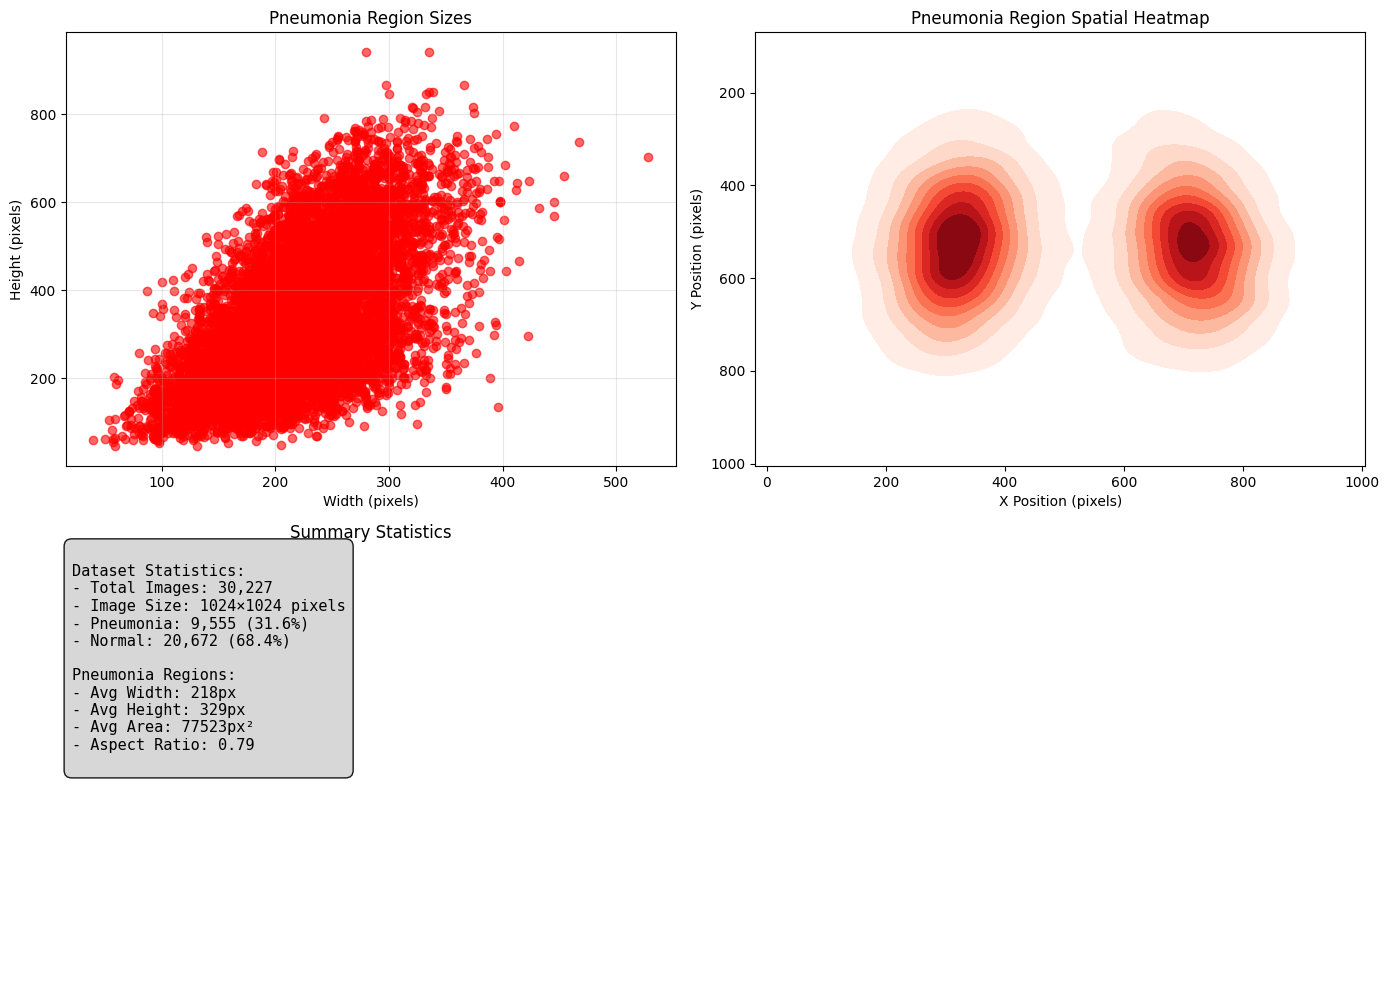

In [ ]:
import matplotlib.patches as patches

# Create a summary visualization of our EDA findings
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Pneumonia Region Sizes
axes[0, 0].scatter(pneumonia_df['width'], pneumonia_df['height'], alpha=0.6, color='red')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Height (pixels)')
axes[0, 0].set_title('Pneumonia Region Sizes')
axes[0, 0].grid(True, alpha=0.3)

# 2. Pneumonia Spatial Distribution
x_centers = pneumonia_df['x'] + pneumonia_df['width'] / 2
y_centers = pneumonia_df['y'] + pneumonia_df['height'] / 2

sns.kdeplot(
    x=x_centers,
    y=y_centers,
    fill=True,
    cmap='Reds',        # Try 'viridis', 'plasma', 'cividis' etc.
    bw_adjust=0.8,
    ax=axes[0, 1],
    thresh=0.05
)
axes[0, 1].invert_yaxis()
axes[0, 1].set_xlabel('X Position (pixels)')
axes[0, 1].set_ylabel('Y Position (pixels)')
axes[0, 1].set_title('Pneumonia Region Spatial Heatmap')

# 3. Summary Statistics (text)
stats_text = f"""
Dataset Statistics:
- Total Images: {len(df):,}
- Image Size: 1024×1024 pixels
- Pneumonia: {(df['Target'] == 1).sum():,} ({100*(df['Target'] == 1).mean():.1f}%)
- Normal: {(df['Target'] == 0).sum():,} ({100*(df['Target'] == 0).mean():.1f}%)

Pneumonia Regions:
- Avg Width: {pneumonia_df['width'].mean():.0f}px
- Avg Height: {pneumonia_df['height'].mean():.0f}px
- Avg Area: {pneumonia_df['area'].mean():.0f}px²
- Aspect Ratio: {pneumonia_df['aspect_ratio'].mean():.2f}
"""

axes[1, 0].axis('off')
axes[1, 0].text(0.01, 1, stats_text, fontsize=11, verticalalignment='top',
                fontfamily='monospace', bbox=dict(boxstyle="round,pad=0.5",
                facecolor="lightgray", alpha=0.9))
axes[1, 0].set_title('Summary Statistics')

# 4. Empty plot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

* In the left Scatter plot we can see that most pneumonia regions fall between 100 and 400 pixels wide and 100-800 pixels high. Easier to see here that most bounding box are medium sized and vertically oriented.

* The heatmap shows the spatial density of penumonia. The 2 hotspots represnt the left and right lungs, where pneumonia is most commonly found. Darker red indicates higher concentraition of bounding box centers. The distribution is symmetric and mostly centered in the mid to lower lung regions, matching typical clinical patterns

# The final pipeline consists of 2 stages:

**1st stage** - Classifier:
- We trained 3 different CNN architectures: **EfficentNet-B4, VGG-16 and DenseNet-121**.

**2nd stage** - Detector:
- Only works if the **classifier predicts Pnuemonia**.

# Stage 1 -  Model Selection and Evaluation:

In this section, we focus on the first stage of our pipeline: selecting and evaluating baseline classification models.

We chose three different architectures to represent a range of model complexities and design philosophies:

- **EfficientNet B4**: Selected for its strong performance-to-complexity ratio. EfficientNet uses compound scaling to balance depth, width, and resolution, making it effective for transfer learning tasks on medical images.

- **VGG-16**: Chosen as a classic convolutional neural network with a simple and well-understood architecture. Its uniform structure makes it a strong baseline for comparison, despite its higher parameter count and limited efficiency.

- **DenseNet-121**: Selected for its efficient feature reuse and compact architecture. DenseNet is known to perform well with relatively fewer parameters by enabling gradient flow and leveraging concatenated feature maps.

Each model produces an output in the form $[p_{\text{normal}},\ p_{\text{pneumonia}}]$, representing the predicted probabilities for the normal and pneumonia classes, respectively.


By evaluating these models under the same conditions, we aim to identify the most promising architecture to move forward with in the pipeline.

## Get required data for classiying (patients ids, traget)

In [ ]:
classification_df = df[['patientId', 'Target']].drop_duplicates()

print("Classification Dataset Preparation:")
print(f"Total samples: {len(classification_df)}")
print(f"Pneumonia cases: {(classification_df['Target'] == 1).sum()}")
print(f"Normal cases: {(classification_df['Target'] == 0).sum()}")

# Verify no duplicates
print(f"Unique patients: {classification_df['patientId'].nunique()}")
print(f"NUmber of duplicates: {classification_df.duplicated().sum()}")



Classification Dataset Preparation:
Total samples: 26684
Pneumonia cases: 6012
Normal cases: 20672
Unique patients: 26684
NUmber of duplicates: 0


## Dataset Organization

After splitting the RSNA dataset into **training**, **validation**, and **test** sets, we move the images into the corresponding folders within the **Kermany dataset** directory structure. This ensures a unified dataset layout for downstream processing and model training.

In [ ]:
train_df, val_test_df = train_test_split(classification_df, test_size=0.1, random_state=42, stratify=classification_df['Target'])
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Target'])

In [ ]:
import shutil
from tqdm import tqdm

rsna_image_dir = os.path.join(rsna_extract_path, 'images')
kermany_base = os.path.join(kermany_extract_path, 'chest_xray')

dest_dirs = {
    'train': {
        0: os.path.join(kermany_base, 'train', 'NORMAL'),
        1: os.path.join(kermany_base, 'train', 'PNEUMONIA')
    },
    'val':{
        0: os.path.join(kermany_base, 'val', 'NORMAL'),
        1: os.path.join(kermany_base, 'val', 'PNEUMONIA')
    },
    'test':{
        0: os.path.join(kermany_base, 'test', 'NORMAL'),
        1: os.path.join(kermany_base, 'test', 'PNEUMONIA')
    }
}

In [ ]:
def copy_images(df, split_name):
  for _, row in tqdm(df.iterrows(), total=len(df), desc=f'Copying {split_name} images'):
    patient_id = row['patientId']
    label = row['Target']

    src_path = os.path.join(rsna_image_dir, f'{patient_id}.jpg')
    dst_path = os.path.join(dest_dirs[split_name][label], f'rsna_{patient_id}.jpg')
    if os.path.exists(src_path):
      shutil.copy(src_path, dst_path)


copy_images(train_df, 'train')
copy_images(val_df, 'val')
copy_images(test_df, 'test')

Copying test images: 100%|██████████| 1335/1335 [00:00<00:00, 3364.16it/s]


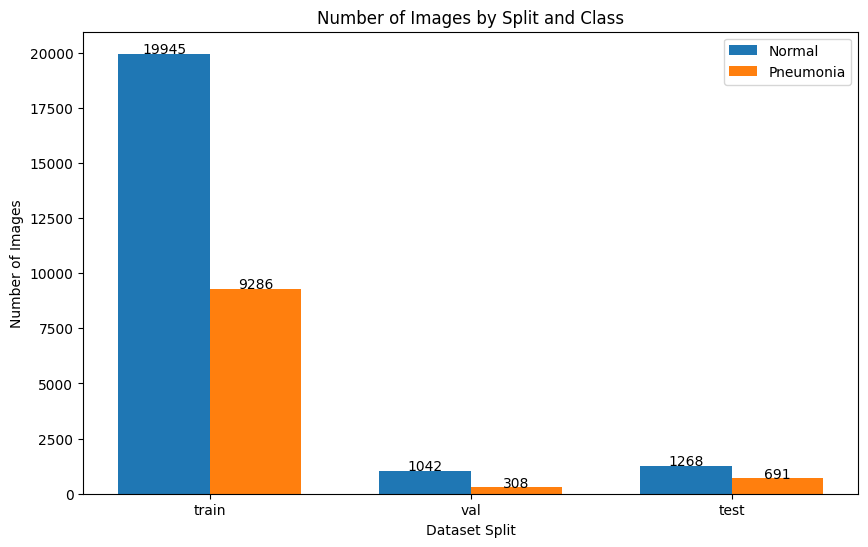

In [ ]:
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

data_counts = {}

for split in splits:
  data_counts[split] = {}
  for cls in classes:
    folder = os.path.join(kermany_base, split, cls)
    data_counts[split][cls] = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg'))])

labels = []
normal_counts = []
pneumonia_counts = []

for split in splits:
  labels.append(split)
  normal_counts.append(data_counts[split]['NORMAL'])
  pneumonia_counts.append(data_counts[split]['PNEUMONIA'])

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, normal_counts, width, label='Normal')
ax.bar([i + width for i in x], pneumonia_counts, width, label='Pneumonia')

ax.set_xlabel('Dataset Split')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images by Split and Class')
ax.set_xticks([i + width / 2 for i in x], labels)
ax.set_xticklabels(labels)
ax.legend()

for i in x:
  ax.text(i, normal_counts[i], str(normal_counts[i]), ha='center')
  ax.text(i + width, pneumonia_counts[i], str(pneumonia_counts[i]), ha='center')

plt.show()

Dataset Distribution by Class and Split

The bar chart above shows the distribution of **Normal** and **Pneumonia** images across the training, validation, and test sets:

- **Training Set**:
  - Normal: 19,945 images
  - Pneumonia: 9,286 images

- **Validation Set**:
  - Normal: 1,042 images
  - Pneumonia: 308 images

- **Test Set**:
  - Normal: 1,268 images
  - Pneumonia: 691 images

The training set contains the majority of the data. There is a noticeable class imbalance in all splits, with **Normal** images outnumbering **Pneumonia** images across all sets.

> **Note:** The **validation set is relatively small**, especially for pneumonia cases. This makes it **sensitive to misclassifications**, which could lead to noisy or unstable model evaluation during training.

### Creating datasets Class,transforms and loaders

Data Preprocessing and Loading:

Through trial and error, we observed that resizing the images to **224×224 pixels** did not negatively impact the model's performance. Therefore, we adopted this resolution to reduce computational cost and training time.

We define preprocessing pipelines and data loaders for the training and validation sets using `torchvision.transforms` and `torch.utils.data`.

Padding to Square:

A custom `PadToSquare` class is implemented to make images square by padding the shorter side with zeros (black pixels). This ensures consistent aspect ratios across the dataset, which is important before resizing.

Transforms:

- **Grayscale → RGB**: Converts grayscale images to 3-channel format using `transforms.Grayscale(num_output_channels=3)` to match the expected input of pre-trained models.
- **PadToSquare**: Pads non-square images to make them square.
- **Resize**: Resizes all images to **224×224 pixels**, a common input size for CNN models.
- **RandomHorizontalFlip** (train only): Applies horizontal flipping with a 50% chance to augment the training data.
- **ToTensor**: Converts PIL images to PyTorch tensors.
- **Normalize**: Normalizes tensors using ImageNet statistics (`mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`) to leverage pre-trained models effectively.

Datasets and DataLoaders:

- The `ImageFolder` class is used to load images from the `train` and `val` directories inside the `kermany_base` path.
- `DataLoader` is used to create mini-batches:
  - `train_loader`: with `shuffle=True` to randomize batches for training.
  - `val_loader`: with `shuffle=False` to ensure consistent evaluation.

In [ ]:
class PadToSquare:
  def __call__(self, image: Image.Image) -> Image.Image:
    w, h = image.size
    diff = abs(h-w)

    if h > w:
      padding = (0, diff//2, 0, diff - diff//2)
    else:
      padding = (diff//2, 0, diff - diff//2, 0)

    return ImageOps.expand(image, border=padding, fill=0)

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    PadToSquare(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    PadToSquare(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(os.path.join(kermany_base, 'train'), transform=train_transforms)
val_dataset = ImageFolder(os.path.join(kermany_base, 'val'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using Device: {device}')

Using Device: cuda


### defining training and validation functions

In [ ]:
def do_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()

    running_loss = 0.0
    all_labels = [] # To store true labels (0s and 1s)
    all_preds = []  # To store predicted class labels (0s and 1s)
    all_probs = []  # To store probabilities (either for the positive class or for both classes)

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device) # Ensure labels are on the correct device

        optimizer.zero_grad() # Zero the parameter gradients before each batch

        outputs = model(images) # Forward pass: get raw model outputs (logits)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        # --- Collect true labels, predictions, and probabilities ---
        all_labels.extend(labels.cpu().numpy()) # Move labels to CPU and convert to NumPy array

        # Model has multiple output neurons (2 for Normal/Pneumonia, for Cross Entropy Loss)
        # The outputs are logits for each class.
        # Apply softmax to get probabilities for all classes ([prob_normal, prob_pneumonia]).
        class_probabilities = F.softmax(outputs, dim=1)
        class_predictions = torch.argmax(outputs, dim=1) # Get the predicted class by finding the index with the highest value
        all_probs.extend(class_probabilities.detach().cpu().numpy()) # Store the probabilities for all classes
        all_preds.extend(class_predictions.detach().cpu().numpy()) # Collect predictions (move to CPU and convert to NumPy array)

    # Calculate the average loss for the entire epoch
    epoch_loss = running_loss / len(dataloader.dataset)

    # Calculate F1 score for binary classification
    # It calculates the F1 score for the positive class (labels are 0 and 1, and 1 is positive class)
    try:
        f1 = f1_score(all_labels, all_preds, average='binary')
    except ValueError as e:
        # This handles cases where f1_score cannot be computed (e.g., if all samples
        # belong to only one class, or if the dataloader was empty).
        print(f"Warning: Could not calculate F1 score. Error: {e}")
        f1 = 0.0

    return epoch_loss, f1

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()

    running_loss = 0.0
    all_labels = [] # To store true labels (0s and 1s)
    all_preds = []  # To store predicted class labels (0s and 1s)

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # Forward pass: get raw model outputs (logits)

            # Calculate loss for the current batch
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0) # Accumulate batch loss

            # --- Collect true labels and predictions ---
            all_labels.extend(labels.cpu().numpy()) # Move labels to CPU and convert to NumPy array

            class_predictions = torch.argmax(outputs, dim=1)

            # Collect predictions (move to CPU and convert to NumPy array)
            all_preds.extend(class_predictions.detach().cpu().numpy())

    # Calculate the average loss for the entire evaluation dataset
    epoch_loss = running_loss / len(dataloader.dataset)

    # Calculate F1 score for binary classification
    # 'average='binary'' is suitable here, as you have 2 classes (Normal, Pneumonia),
    # and it computes the F1 score for the positive class (assuming it's labeled as 1).
    try:
        f1 = f1_score(all_labels, all_preds, average='binary')
    except ValueError as e:
        # This handles cases where f1_score cannot be computed (e.g., if only one class
        # is present in the true labels or predictions, or if the dataloader was empty).
        print(f"Warning: Could not calculate F1 score. Error: {e}")
        f1 = 0.0 # Return 0 or np.nan as an indicator for this edge case

    return epoch_loss, f1

## Classification models



### Transfer Learning with EfficentNet- B4

In [ ]:
effnet = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)

# Freeze all layers except the classifier
for name, param in effnet.named_parameters():
    if not name.startswith("classifier"):
        param.requires_grad = False

# Replace the classifier head
effnet.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 196MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, effnet.parameters()), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

In [ ]:
best_f1 = 0.0
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

stage = 0
epoch_no_improve = 0

num_epochs = 50
effnet.to(device)

for epoch in range(num_epochs):
    print("-" * 20)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    train_loss, train_f1 = do_one_epoch(effnet, train_loader, criterion, optimizer, device)
    val_loss, val_f1 = evaluate(effnet, val_loader, criterion, device)
    scheduler.step(val_f1)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(effnet.state_dict(), os.path.join(models_dir, 'best_efficentnet.pth'))
        print(f"    ==> Saved Best Model with F1 score: {best_f1:.4f}")
        epoch_no_improve = 0
    else:
        epoch_no_improve += 1

    if epoch == 9:
        for name, param in effnet.named_parameters():
            if name.startswith("features.7") or name.startswith("features.8") or name.startswith("features.6"):
                param.requires_grad = True
        for m in effnet.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
                for param in m.parameters():
                    param.requires_grad = True

        optimizer = optim.Adam(filter(lambda p: p.requires_grad, effnet.parameters()), lr=0.0001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1)
        print('> Unfroze Layer 6, 7 and 8')
        stage = 1
        epoch_no_improve = 0

    elif stage == 1 and epoch_no_improve == 7:
        print('Early stopped triggered.')
        break
print('Training Complete')
print(f"Best F1 Score: {best_f1:.4f}")


--------------------
Epoch 1/50:
Train Loss: 0.4064 | Train F1: 0.6567 | Val Loss: 0.3956 | Val F1: 0.4877
    ==> Saved Best Model with F1 score: 0.4877
--------------------
Epoch 2/50:
Train Loss: 0.3811 | Train F1: 0.6901 | Val Loss: 0.4006 | Val F1: 0.4768
--------------------
Epoch 3/50:
Train Loss: 0.3760 | Train F1: 0.6903 | Val Loss: 0.3944 | Val F1: 0.5341
    ==> Saved Best Model with F1 score: 0.5341
--------------------
Epoch 4/50:
Train Loss: 0.3738 | Train F1: 0.6957 | Val Loss: 0.3881 | Val F1: 0.4469
--------------------
Epoch 5/50:
Train Loss: 0.3694 | Train F1: 0.6991 | Val Loss: 0.3882 | Val F1: 0.5290
--------------------
Epoch 6/50:
Train Loss: 0.3671 | Train F1: 0.7024 | Val Loss: 0.3871 | Val F1: 0.4564
--------------------
Epoch 7/50:
Train Loss: 0.3554 | Train F1: 0.7030 | Val Loss: 0.3827 | Val F1: 0.5236
--------------------
Epoch 8/50:
Train Loss: 0.3527 | Train F1: 0.7130 | Val Loss: 0.3812 | Val F1: 0.5020
--------------------
Epoch 9/50:
Train Loss: 0.350

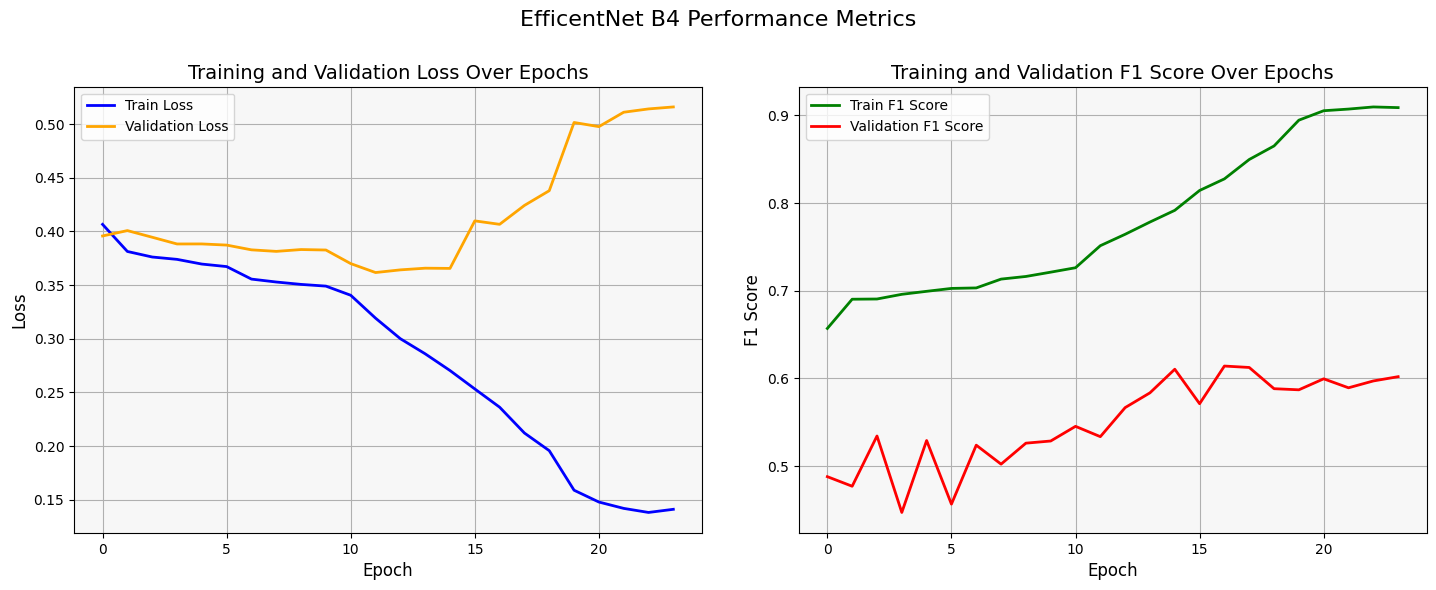

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns, adjust figsize as needed

# --- Plot Loss on the first subplot (left) ---
axes[0].plot(train_losses, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[0].set_title('Training and Validation Loss Over Epochs', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)
axes[0].set_facecolor('#f7f7f7') # Optional: light background color

# --- Plot F1 Score on the second subplot (right) ---
axes[1].plot(train_f1s, label='Train F1 Score', color='green', linewidth=2)
axes[1].plot(val_f1s, label='Validation F1 Score', color='red', linewidth=2)
axes[1].set_title('Training and Validation F1 Score Over Epochs', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)
axes[1].set_facecolor('#f7f7f7') # Optional: light background color

# --- Adjust layout and display the plot ---
plt.tight_layout(pad=3.0) # Adjusts subplot params for a tight layout
plt.suptitle('EfficentNet B4 Performance Metrics', fontsize=16, y=1.02) # Overall title for the figure
plt.show()

### Transfer Learning VGG-16

In [ ]:
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

for param in vgg.parameters():
    param.requires_grad = False

vgg.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(1024, 2)  # Binary classification (Normal, Pneumonia)
)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 207MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg.parameters()), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

In [ ]:
best_f1 = 0.0
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []
stage = 0
epoch_no_improve = 0

num_epochs = 50
vgg.to(device)

for epoch in range(num_epochs):
    print("-" * 20)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    train_loss, train_f1 = do_one_epoch(vgg, train_loader, criterion, optimizer, device)
    val_loss, val_f1 = evaluate(vgg, val_loader, criterion, device)
    scheduler.step(val_f1)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(vgg.state_dict(), os.path.join(models_dir, 'best_vgg.pth'))
        print(f"    ==> Saved Best Model with F1 score: {best_f1:.4f}")
        epoch_no_improve = 0
    else:
        epoch_no_improve += 1

    if epoch == 9:
        for param in vgg.features[24:].parameters():
            param.requires_grad = True
        print('> Unfroze Block 5')
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg.parameters()), lr=0.0001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1)
        stage = 1
        epoch_no_improve = 0

    elif stage == 1 and epoch_no_improve == 7:
        print('Early stopped triggered.')
        break

print('Training Complete')
print(f"Best F1 Score: {best_f1:.4f}")


--------------------
Epoch 1/50:
Train Loss: 0.4441 | Train F1: 0.6702 | Val Loss: 0.3966 | Val F1: 0.5282
    ==> Saved Best Model with F1 score: 0.5282
--------------------
Epoch 2/50:
Train Loss: 0.3971 | Train F1: 0.6690 | Val Loss: 0.4395 | Val F1: 0.4122
--------------------
Epoch 3/50:
Train Loss: 0.3793 | Train F1: 0.6823 | Val Loss: 0.3982 | Val F1: 0.3081
--------------------
Epoch 4/50:
Train Loss: 0.3658 | Train F1: 0.6884 | Val Loss: 0.3905 | Val F1: 0.4637
--------------------
Epoch 5/50:
Train Loss: 0.3350 | Train F1: 0.7148 | Val Loss: 0.3865 | Val F1: 0.5055
--------------------
Epoch 6/50:
Train Loss: 0.3277 | Train F1: 0.7203 | Val Loss: 0.3985 | Val F1: 0.5053
--------------------
Epoch 7/50:
Train Loss: 0.3213 | Train F1: 0.7312 | Val Loss: 0.3925 | Val F1: 0.5033
--------------------
Epoch 8/50:
Train Loss: 0.3153 | Train F1: 0.7403 | Val Loss: 0.3904 | Val F1: 0.5096
--------------------
Epoch 9/50:
Train Loss: 0.3140 | Train F1: 0.7422 | Val Loss: 0.3894 | Val F

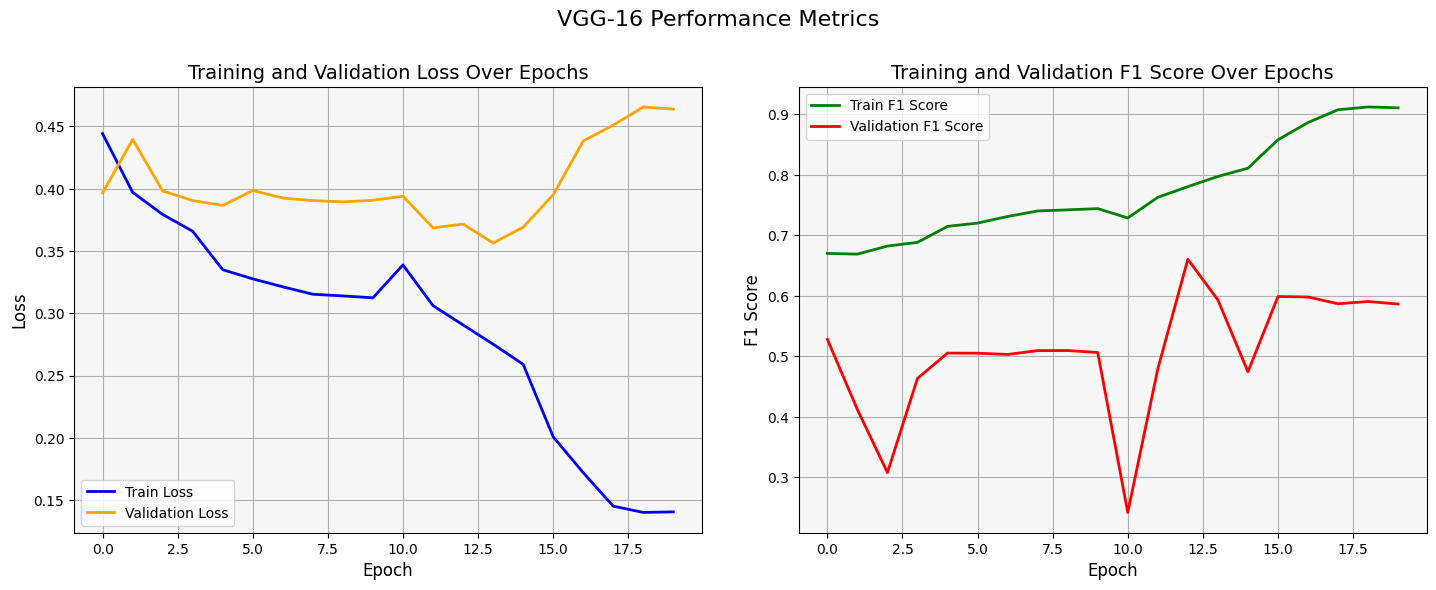

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns, adjust figsize as needed

# --- Plot Loss on the first subplot (left) ---
axes[0].plot(train_losses, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[0].set_title('Training and Validation Loss Over Epochs', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)
axes[0].set_facecolor('#f7f7f7') # Optional: light background color

# --- Plot F1 Score on the second subplot (right) ---
axes[1].plot(train_f1s, label='Train F1 Score', color='green', linewidth=2)
axes[1].plot(val_f1s, label='Validation F1 Score', color='red', linewidth=2)
axes[1].set_title('Training and Validation F1 Score Over Epochs', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)
axes[1].set_facecolor('#f7f7f7') # Optional: light background color

# --- Adjust layout and display the plot ---
plt.tight_layout(pad=3.0) # Adjusts subplot params for a tight layout
plt.suptitle('VGG-16 Performance Metrics', fontsize=16, y=1.02) # Overall title for the figure
plt.show()

### Transfer Learning DenseNet-121

In [ ]:
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

for param in densenet.parameters():
    param.requires_grad = False

densenet.classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(512, 2)
)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 225MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, densenet.parameters()), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

In [ ]:
best_f1 = 0.0
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []
stage = 0
epoch_no_improve = 0

num_epochs = 50
densenet.to(device)

for epoch in range(num_epochs):
    print("-" * 20)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    train_loss, train_f1 = do_one_epoch(densenet, train_loader, criterion, optimizer, device)
    val_loss, val_f1 = evaluate(densenet, val_loader, criterion, device)
    scheduler.step(val_f1)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(densenet.state_dict(), os.path.join(models_dir, 'best_densenet.pth'))
        print(f"    ==> Saved Best Model with F1 score: {best_f1:.4f}")
        epoch_no_improve = 0
    else:
        epoch_no_improve += 1

    if epoch == 9:
        for name, param in densenet.named_parameters():
            if any(k in name for k in ['denseblock3', 'transition3', 'denseblock4', 'norm5']):
                param.requires_grad = True
        print('> Unfroze Block 5')
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, densenet.parameters()), lr=0.0001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)
        stage = 1
        epoch_no_improve = 0

    elif stage == 1 and epoch_no_improve == 7:
        print('Early stopped triggered.')
        break

print('Training Complete')
print(f"Best F1 Score: {best_f1:.4f}")


--------------------
Epoch 1/50:
Train Loss: 0.4243 | Train F1: 0.6380 | Val Loss: 0.4087 | Val F1: 0.5550
    ==> Saved Best Model with F1 score: 0.5550
--------------------
Epoch 2/50:
Train Loss: 0.3929 | Train F1: 0.6640 | Val Loss: 0.4059 | Val F1: 0.4253
--------------------
Epoch 3/50:
Train Loss: 0.3830 | Train F1: 0.6693 | Val Loss: 0.4304 | Val F1: 0.6008
    ==> Saved Best Model with F1 score: 0.6008
--------------------
Epoch 4/50:
Train Loss: 0.3824 | Train F1: 0.6659 | Val Loss: 0.3979 | Val F1: 0.4671
--------------------
Epoch 5/50:
Train Loss: 0.3788 | Train F1: 0.6777 | Val Loss: 0.3979 | Val F1: 0.5341
--------------------
Epoch 6/50:
Train Loss: 0.3757 | Train F1: 0.6711 | Val Loss: 0.4151 | Val F1: 0.5901
--------------------
Epoch 7/50:
Train Loss: 0.3582 | Train F1: 0.7030 | Val Loss: 0.3966 | Val F1: 0.5392
--------------------
Epoch 8/50:
Train Loss: 0.3543 | Train F1: 0.6982 | Val Loss: 0.3936 | Val F1: 0.5424
--------------------
Epoch 9/50:
Train Loss: 0.354

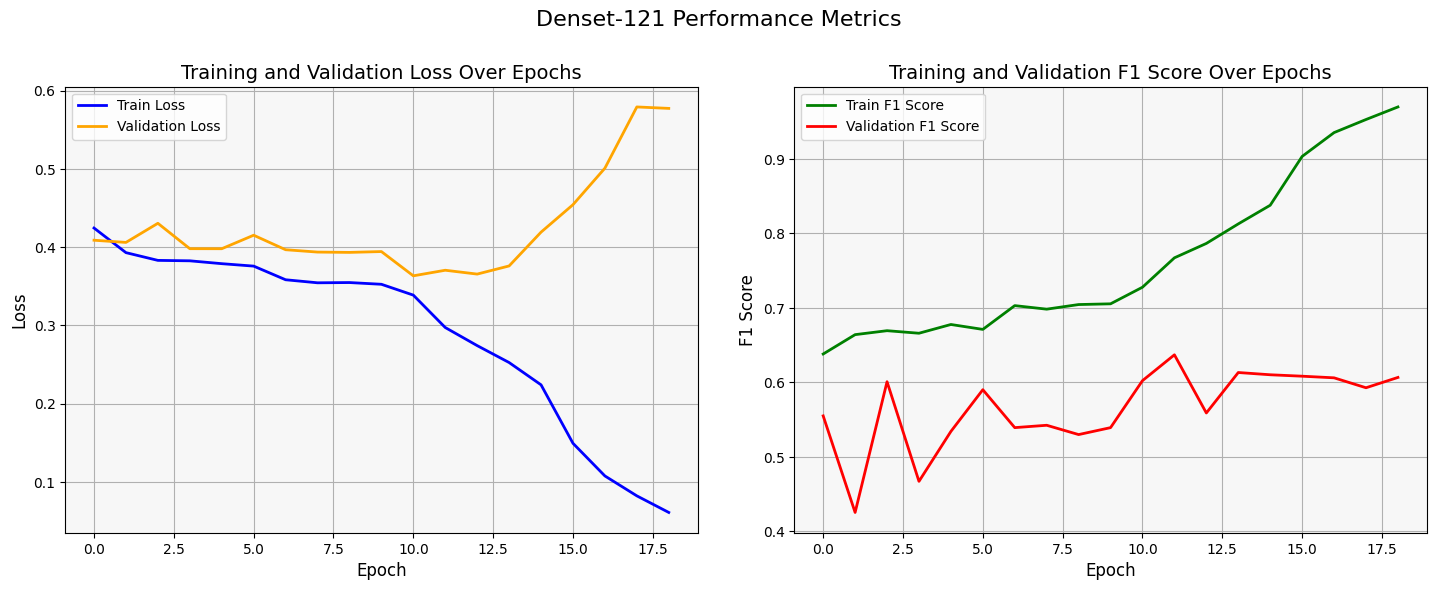

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns, adjust figsize as needed

# --- Plot Loss on the first subplot (left) ---
axes[0].plot(train_losses, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[0].set_title('Training and Validation Loss Over Epochs', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)
axes[0].set_facecolor('#f7f7f7') # Optional: light background color

# --- Plot F1 Score on the second subplot (right) ---
axes[1].plot(train_f1s, label='Train F1 Score', color='green', linewidth=2)
axes[1].plot(val_f1s, label='Validation F1 Score', color='red', linewidth=2)
axes[1].set_title('Training and Validation F1 Score Over Epochs', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)
axes[1].set_facecolor('#f7f7f7') # Optional: light background color

# --- Adjust layout and display the plot ---
plt.tight_layout(pad=3.0) # Adjusts subplot params for a tight layout
plt.suptitle('Denset-121 Performance Metrics', fontsize=16, y=1.02) # Overall title for the figure
plt.show()

## Model Performance Comparison:


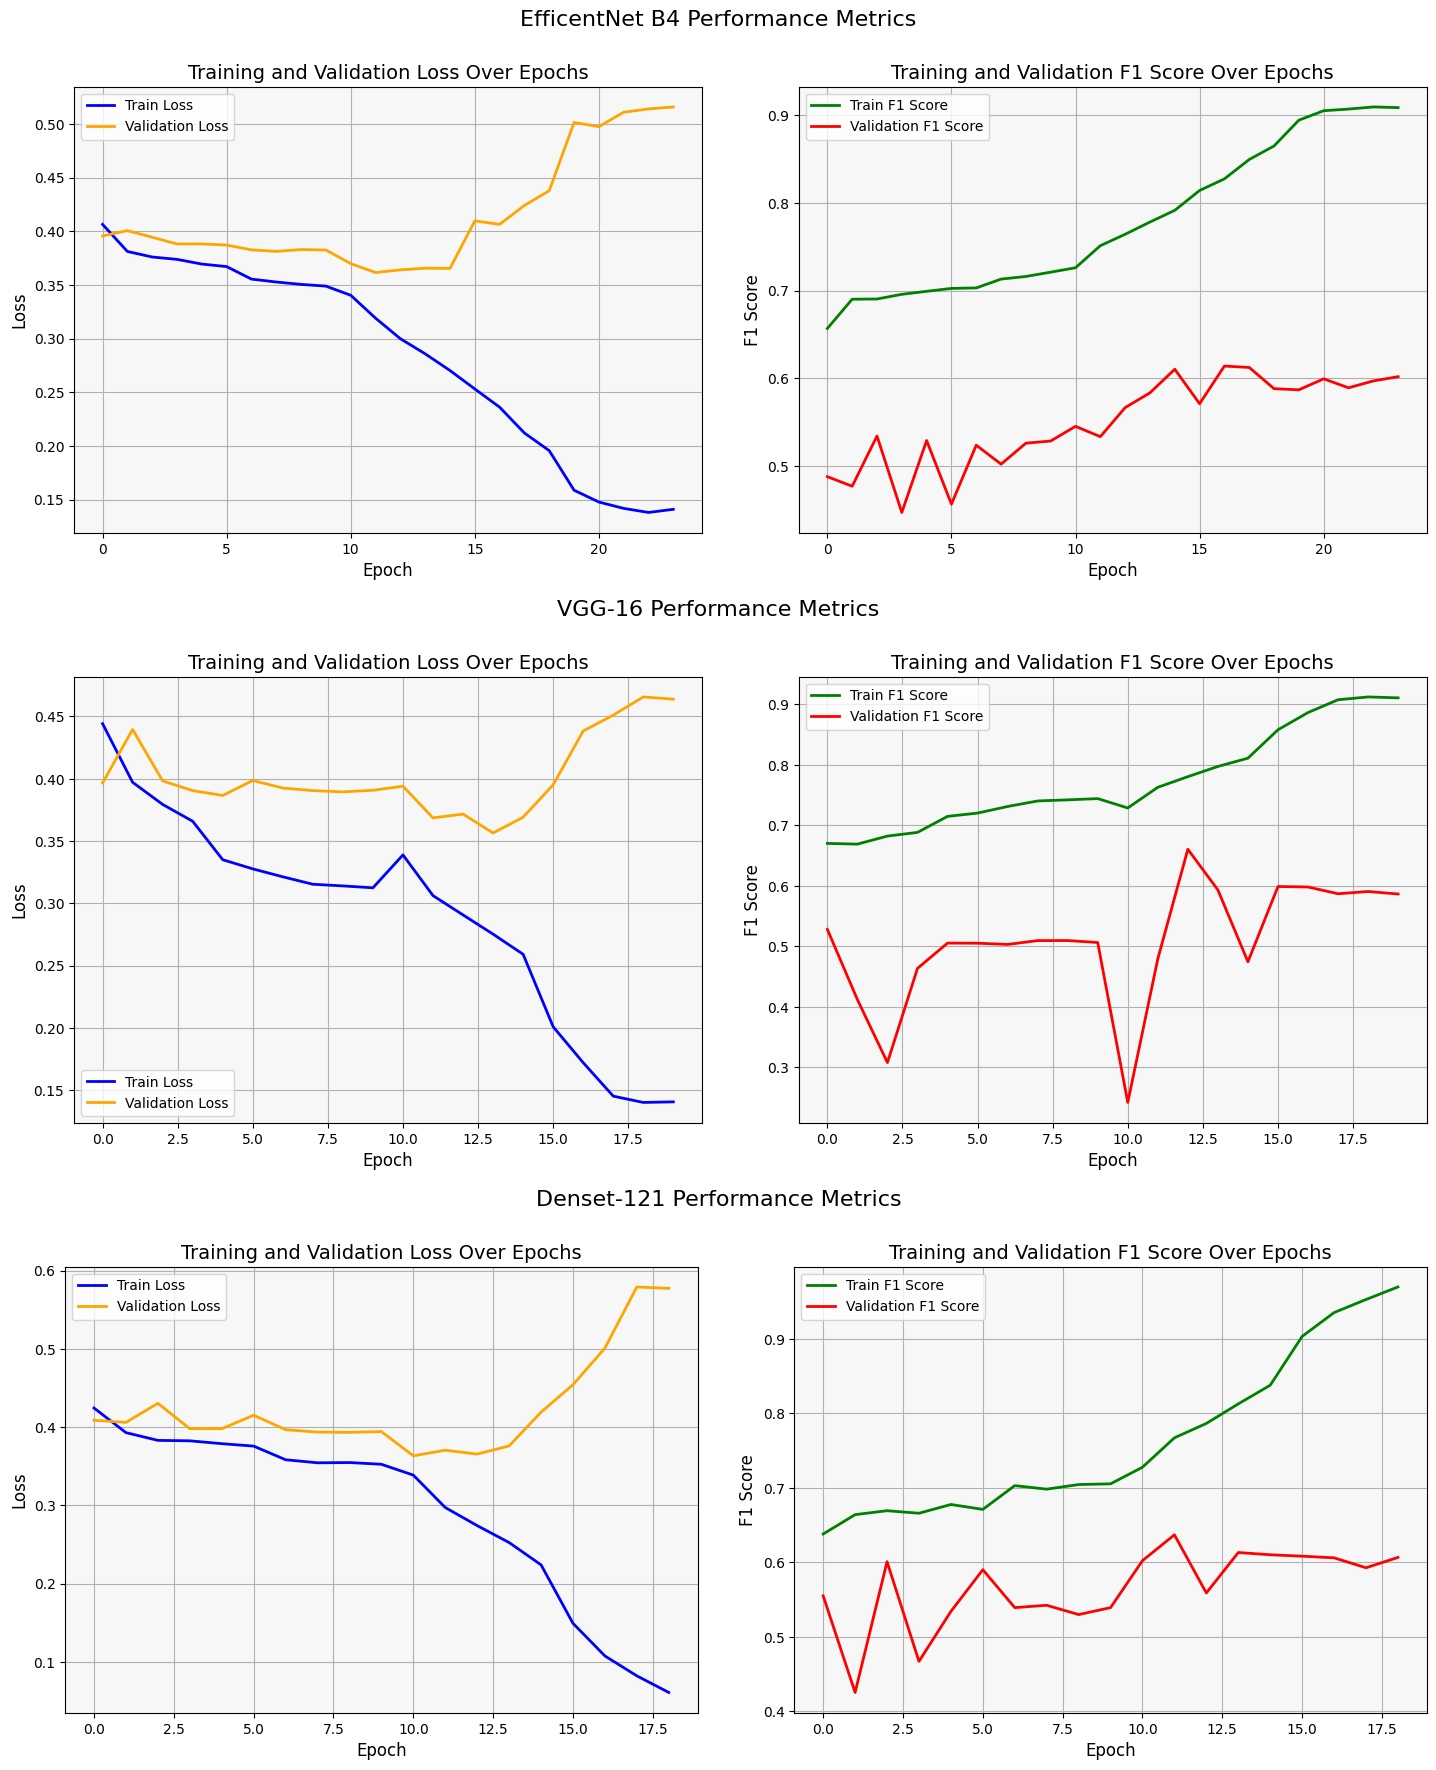


In the plots above, we can see the training and validation performance of three architectures — DenseNet-121, VGG-16, and EfficientNet B4 — across multiple epochs:

**EfficientNet B4**
- **Loss**: Exhibits a strong downward trend in training loss and relatively stable validation loss with some increase toward the end.
- **F1 Score**: Demonstrates the most consistent improvement in training F1. The validation F1 score is more stable than the other models but shows only moderate gains.

**VGG-16**
- **Loss**: Similar trend as DenseNet-121, with declining training loss and rising validation loss in later epochs.
- **F1 Score**: The training F1 score improves consistently. The validation F1 score, however, exhibits significant volatility.

**DenseNet-121:**
- **Loss**: Training loss steadily decreases, while validation loss initially plateaus and then increases, indicating possible overfitting.
- **F1 Score**: The training F1 score consistently improves, but the validation F1 score fluctuates and shows limited improvement.

Despite applying various data augmentation techniques to improve generalization, the overfitting persisted, particularly in DenseNet-121 and VGG-16. As a result, we opted to simplify the preprocessing pipeline by retaining only horizontal flipping and resizing the images to 224×224, which helped reduce computation without further degrading model performance.

### Testing Classifications models

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def test_model(model, dataloader, device):
  model.to(device)
  model.eval()

  y_true = []
  y_pred = []
  y_scores = []

  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device).long()

      logits = model(images)
      probs = F.softmax(logits, dim=1)
      preds = torch.argmax(probs, dim=1)
      pos_probs = probs[:, 1]

      y_true.extend(labels.cpu().numpy())
      y_pred.extend(preds.cpu().numpy())
      y_scores.extend(pos_probs.cpu().numpy())

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, zero_division=0)
  recall = recall_score(y_true, y_pred, zero_division=0)
  f1 = f1_score(y_true, y_pred, zero_division=0)
  auc = roc_auc_score(y_true, y_scores)

  model.cpu()
  return {
          'true': y_true,
          'predicted': y_pred,
          'accuracy': accuracy,
          'precision': precision,
          'recall': recall,
          'f1': f1,
          'auc': auc
  }

test_dataset = ImageFolder(os.path.join(kermany_base, 'test'), transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Testing EfficentNet- B4

In [ ]:
def get_effnet_model():
  effnet = models.efficientnet_b4()

  effnet.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
  )
  effnet.load_state_dict(torch.load(os.path.join(models_dir, 'best_efficentnet.pth')))
  return effnet

In [ ]:
effnet = get_effnet_model()

effnet_score = test_model(effnet, test_loader, device)

print('EfficentNet B4 Testing Complete')

EfficentNet B4 Testing Complete


#### Testing VGG-16

In [ ]:
def get_vgg_model():
  vgg = models.vgg16()

  vgg.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(1024, 2)  # Binary classification (Normal, Pneumonia)
)
  vgg.load_state_dict(torch.load(os.path.join(models_dir, 'best_vgg.pth')))
  return vgg

In [ ]:
vgg = get_vgg_model()

vgg_score = test_model(vgg, test_loader, device)

print('VGG-16 Testing Complete')

VGG-16 Testing Complete


#### Testing DenseNet-121

In [ ]:
def get_densenet_model():
  densenet = models.densenet121()

  densenet.classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(512, 2)
  )
  densenet.load_state_dict(torch.load(os.path.join(models_dir, 'best_densenet.pth')))
  return densenet

In [ ]:
densenet = get_densenet_model()

densenet_score = test_model(densenet, test_loader, device)

print('DenseNet-121 Testing Complete')

DenseNet-121 Testing Complete


#### plotting results

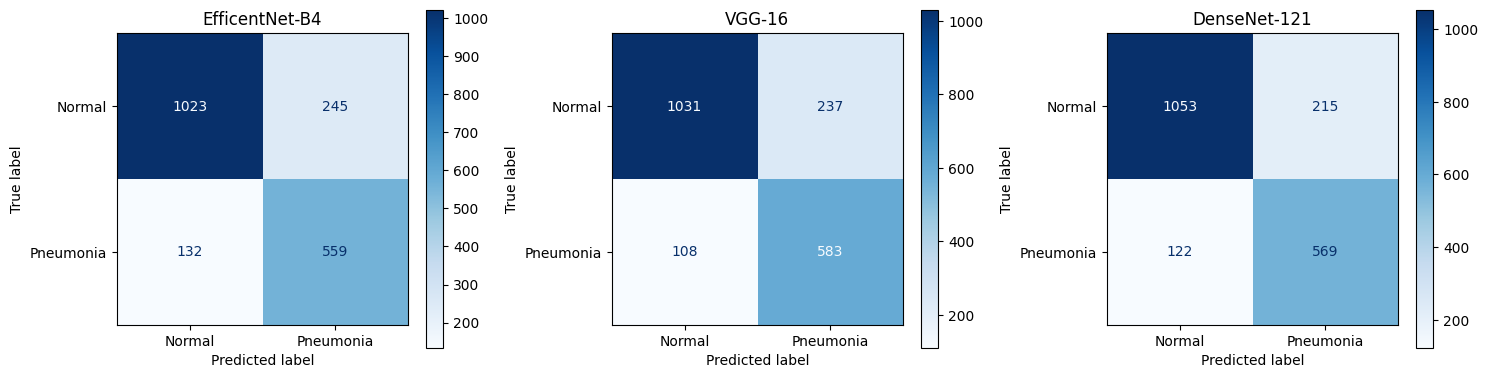

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models_results = [
    ("EfficentNet-B4", effnet_score),
    ("VGG-16", vgg_score),
    ("DenseNet-121", densenet_score)
]

class_labels = ["Normal", "Pneumonia"]  # 0 = Normal, 1 = Pneumonia

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, res) in enumerate(models_results):
    cm = confusion_matrix(res['true'], res['predicted'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')
    axes[i].set_title(name)

plt.tight_layout()
plt.show()

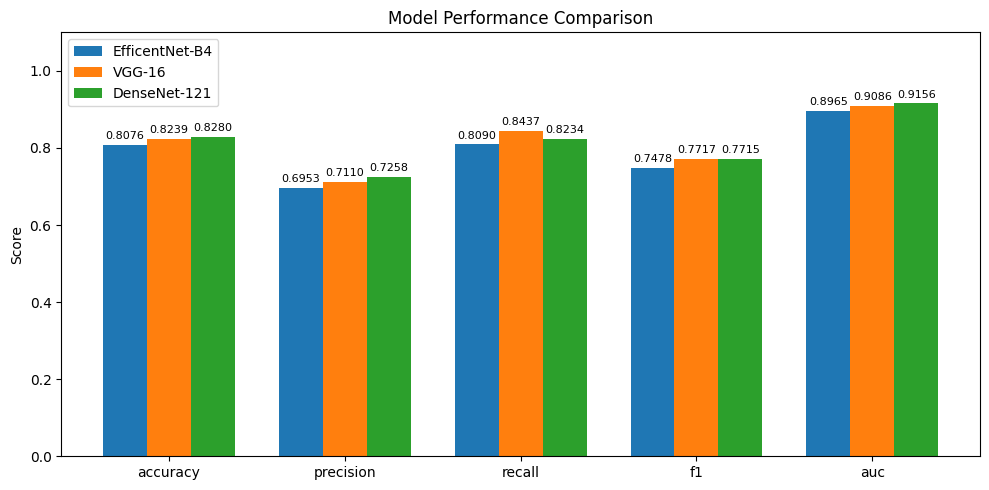

In [ ]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']

# Extract values
metric_values = [
    [effnet_score[m] for m in metrics],
    [vgg_score[m] for m in metrics],
    [densenet_score[m] for m in metrics],
]

labels = ['EfficentNet-B4', 'VGG-16', 'DenseNet-121']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(3):
    bars = ax.bar(x + i*width, metric_values[i], width, label=labels[i])
    # Annotate each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,  # Slightly above the bar
            f'{height:.4f}',
            ha='center',
            va='bottom',
            fontsize=8
        )

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Model Performance Metrics Comparison


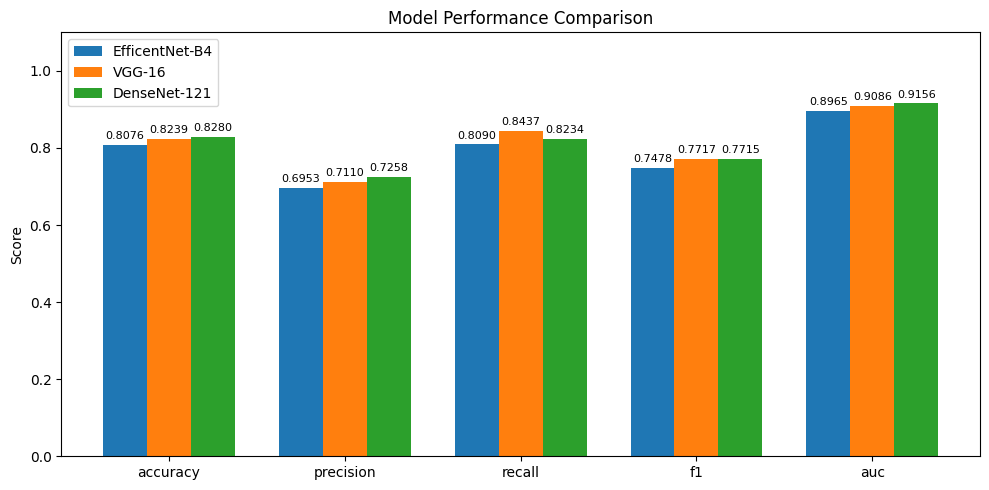

The bar chart above presents a comparison of the three selected architectures — EfficientNet-B4, VGG-16, and DenseNet-121 — across five evaluation metrics: accuracy, precision, recall, F1 score, and AUC.

- **Accuracy**: All models achieved comparable accuracy, with DenseNet-121 performing slightly better (0.8280) than EfficientNet-B4 (0.8076) and VGG-16 (0.8239).
- **Precision**: VGG-16 and DenseNet-121 outperform EfficientNet-B4 in precision, with VGG-16 achieving the highest value (0.7110), suggesting fewer false positives.
- **Recall**: VGG-16 leads in recall (0.8437), indicating strong sensitivity to true positives.
- **F1 Score**: All models perform similarly in terms of F1 score, with VGG-16 slightly ahead (0.7717), reflecting a balanced precision-recall tradeoff.
- **AUC**: DenseNet-121 has the highest AUC (0.9156), demonstrating superior overall classification performance in distinguishing between positive and negative classes.

While all three models perform well, DenseNet-121 shows a slight edge in overall discriminative ability (AUC), whereas VGG-16 offers the best balance between precision and recall. EfficientNet-B4, despite being slightly lower in most metrics, remains competitive and more efficient in terms of parameter count and scalability.

### Ensemble Strategy

Instead of selecting a single best-performing model among the three, we explored whether combining all three architectures could lead to improved performance.

The intuition behind this ensemble approach is that each model may learn different aspects or patterns from the data. By aggregating their predictions, we aim to reduce individual model biases and improve overall robustness and generalization.

We experimented with a simple ensemble technique by averaging the predicted probabilities from EfficientNet-B4, VGG-16, and DenseNet-121. The final prediction was then obtained by thresholding the averaged probability.

This strategy allows us to leverage the strengths of all three models, potentially achieving better classification performance than any individual model alone.

We used a **weighted average** of the predicted outputs from the three models to compute the final ensemble prediction.

Each model produces an output in the form $[p_{\text{normal}},\ p_{\text{pneumonia}}]$, representing class probabilities. To combine these, we assigned a weight to each model based on its performance across multiple evaluation metrics.

#### Computing Weights

For each model $i$, we first constructed a performance vector:

$$
A^{(i)} = \{ \text{Pre}_i, \text{Rec}_i, F1_i, AUC_i \}
$$

We then computed the model's weight using the sum of the hyperbolic tangent of each metric:

$$
w^{(i)} = \sum_{x \in A^{(i)}} \tanh(x)
$$

This smooth non-linear transformation ensures that high-performing models are emphasized, while reducing the influence of outliers.

#### Ensemble Prediction

The ensembled probability for class $j$ is computed as a weighted average:

$$
\text{ens}_j = \frac{\sum_i w^{(i)} \cdot p^{(i)}_j}{\sum_i w^{(i)}}
$$

Finally, the class with the highest ensemble probability is selected as the prediction:

$$
\text{prediction} = \arg\max(\text{ens})
$$

This approach allows us to leverage the strengths of all models while prioritizing those with higher reliability based on multiple evaluation metrics.

**Note:** In the final pipeline, we achieved better results by using a threshold of 0.45 for detecting pneumonia. However, at this stage, we followed the standard approach, where the predicted class is determined by the **argmax** of the weighted average of the class probabilities.


In [ ]:
class ImageFolderWithFilenames(ImageFolder):
    def __getitem__(self, index):
        # Get image path and label
        path, label = self.samples[index]

        # Load the image
        image = self.loader(path)  # default uses PIL.Image.open
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)

        # Extract the filename only
        filename = os.path.basename(path)

        return image, label, filename

#### Save models probailities

In [ ]:
def save_model_probs(model, dataloader, device, output_csv_path):
  model.to(device)
  model.eval()
  results = []

  with torch.no_grad():
    for images, labels, filenames in dataloader:
      images = images.to(device)
      outputs = model(images)
      probs = F.softmax(outputs, dim=1)

      for i in range(len(images)):
        results.append({
            'filename': filenames[i],
            'prob_normal': probs[i][0].item(),
            'prob_pneumonia': probs[i][1].item(),
            'label': labels[i].item()
        })

  df = pd.DataFrame(results)
  df.to_csv(output_csv_path, index=False)
  print(f'Saved probabilities to {output_csv_path}')

In [ ]:
val_dataset = ImageFolderWithFilenames(root=os.path.join(kermany_base, 'val'), transform=val_transforms)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
save_model_probs(effnet, val_loader, device, 'effnet_probs.csv')
save_model_probs(vgg, val_loader, device, 'vgg_probs.csv')
save_model_probs(densenet, val_loader, device, 'densenet_probs.csv')

Saved probabilities to effnet_probs.csv
Saved probabilities to vgg_probs.csv
Saved probabilities to densenet_probs.csv


#### Compute Metrics and Weights

In [ ]:
def compute_model_metrics(csv_path):
  df = pd.read_csv(csv_path)

  y_true = df['label']
  y_probs = df[['prob_normal', 'prob_pneumonia']].values

  y_pred = np.argmax(y_probs, axis=1)

  precision = precision_score(y_true, y_pred, zero_division=0)
  recall = recall_score(y_true, y_pred, zero_division=0)
  f1 = f1_score(y_true, y_pred, zero_division=0)
  auc = roc_auc_score(y_true, y_probs[:, 1])

  return {
      'precision': precision,
      'recall': recall,
      'f1': f1,
      'auc': auc
      }

The ensemble model combines predictions from multiple base models using a weighted strategy based on their individual performance metrics.

1. Performance Metric Collection

  $$
      A_i = \{Pre_i, Rec_i, F1_i, AUC_i\}
  $$

  where:

  * $ Pre_i $ = Precision of model $ i $

  * $ Rec_i $ = Recall of model $ i $

  * $ F1_i $ = F1-score of model $ i $

  * $ AUC_i $ = AUC score of model $ i $

2. Weight Calcualtaion

  Compute the weight $ w^{(i)} $ for each model by applying the hyperbolic tangent dunction to each metric and summing:

$$
  w^{(i)} = \sum_{x \in A^{(i)}} \tanh(x)
$$

3. Ensembled Probability Calculation

  for each class $ j $, calculate the ensambled probability score $ ens_j $ using a weighted average of model predictions:

  $$
  ens_j = \frac{ \sum_{i } w^{(i)} \cdot p_j^{(i)} }{ \sum_{i} w^{(i)} }
  $$

  where $ p_j^{(i)} $ is the the probability predicted by model $ i $ for class $ j $.

In [ ]:
def compute_weights(metrics_list):
    raw_scores = []

    for metrics in metrics_list:
        metrics_vector = np.array([
            metrics['precision'],
            metrics['recall'],
            metrics['f1'],
            metrics['auc']
        ])
        combined_score = np.sum(np.tanh(metrics_vector))
        raw_scores.append(combined_score)

    raw_scores = np.array(raw_scores)
    weights = raw_scores / np.sum(raw_scores)  # Weighted average normalization
    return weights


In [ ]:
effnet_metrics = compute_model_metrics('effnet_probs.csv')
vgg_metrics = compute_model_metrics('vgg_probs.csv')
densenet_metrics = compute_model_metrics('densenet_probs.csv')

metrics_list = [effnet_metrics, vgg_metrics, densenet_metrics]
weights = compute_weights(metrics_list)

print("Model Weights:", weights)

Model Weights: [0.32609051 0.34048762 0.33342187]


#### Ensemble Test Predictions Using Weights

In [ ]:
test_dataset = ImageFolderWithFilenames(root=os.path.join(kermany_base, 'test'), transform=val_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
save_model_probs(effnet, test_loader, device, 'effnet_probs_test.csv')
save_model_probs(vgg, test_loader, device, 'vgg_probs_test.csv')
save_model_probs(densenet, test_loader, device, 'densenet_probs_test.csv')

Saved probabilities to effnet_probs_test.csv
Saved probabilities to vgg_probs_test.csv
Saved probabilities to densenet_probs_test.csv


In [ ]:
def ensemble_predictions(weight_list, prob_paths):
  dfs = [pd.read_csv(path) for path in prob_paths]

  for df in dfs:
    df.sort_values('filename', inplace=True)
    df.reset_index(drop=True, inplace=True)

  filenames = dfs[0]['filename'].values
  ground_truth = dfs[0]['label'].values

  prob_normal = sum(w * df['prob_normal'] for w, df in zip(weight_list, dfs))
  prob_pneumonia = sum(w * df['prob_pneumonia'] for w, df in zip(weight_list, dfs))

  final_probs= np.vstack([prob_normal, prob_pneumonia]).T

  final_preds = np.argmax(final_probs, axis=1)

  precision = precision_score(ground_truth, final_preds, zero_division=0)
  recall = recall_score(ground_truth, final_preds, zero_division=0)
  f1 = f1_score(ground_truth, final_preds, zero_division=0)
  auc = roc_auc_score(ground_truth, prob_pneumonia)

  return {
      'precision': precision,
      'recall': recall,
      'f1': f1,
      'auc': auc
  }, ground_truth, final_preds

In [ ]:
def plot_metrics(metrics_dict, title='Ensemble Model Performance'):
    names = list(metrics_dict.keys())
    values = [metrics_dict[k] for k in names]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(names, values)

    plt.ylim(0, 1.05)
    plt.title(title)
    plt.ylabel("Score")
    plt.grid(axis='y')

    # Add value labels above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.02, f"{height:.2f}", ha='center')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, class_names=['Normal', 'Pneumonia'], title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

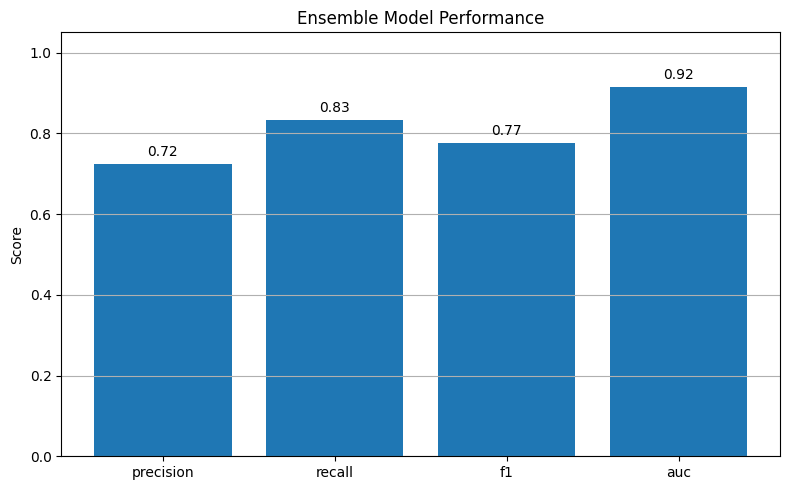

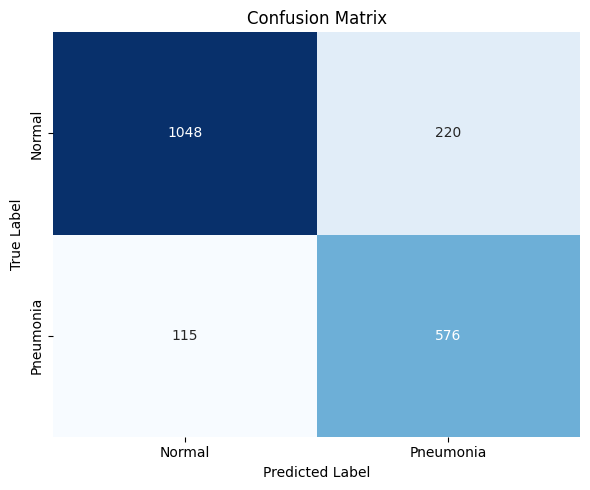

In [ ]:
csv_paths = ['effnet_probs_test.csv', 'vgg_probs_test.csv', 'densenet_probs_test.csv']

ensemble_metrics, y_true, y_pred = ensemble_predictions(weights, csv_paths)
plot_metrics(ensemble_metrics)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

# Result of Classification models


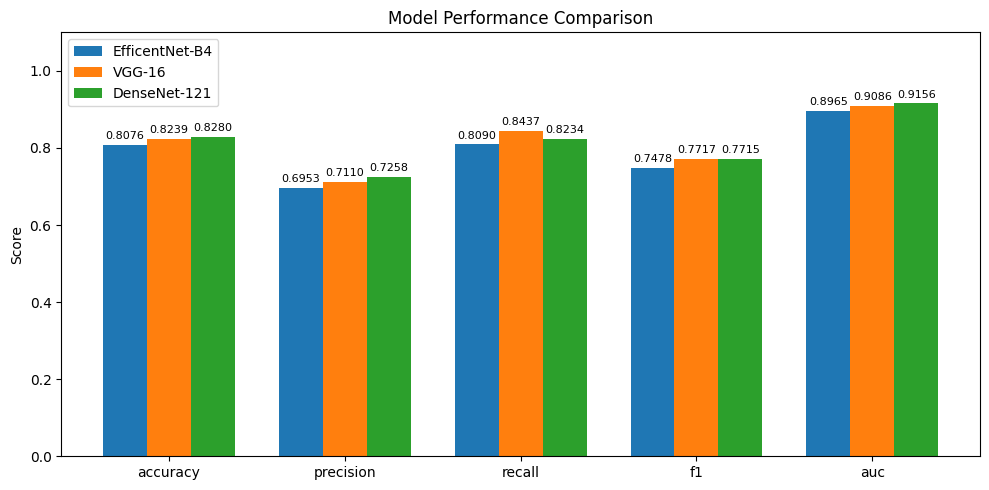

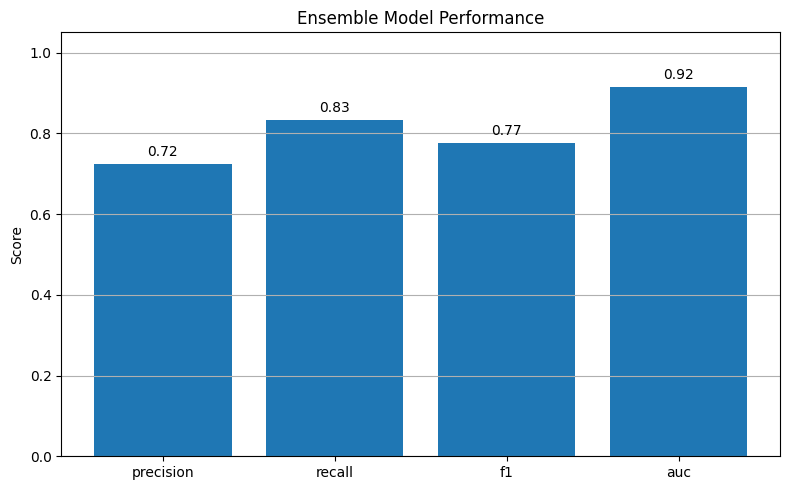

Based on the evaluation plots above:

#### 1. Ensemble Model
- **AUC**: Achieves the highest AUC of **0.92**, indicating superior ability to distinguish between normal and pneumonia cases.
- **Recall**: Maintains a strong recall of **0.83**, ensuring most pneumonia cases are correctly identified.
- **Precision**: While the precision is **0.72**, it is still higher than that of any individual model, reflecting improved reliability in positive predictions.

#### 2. Individual Models
- **DenseNet-121**: Exhibits the highest AUC (**0.9156**) and best precision among the individual models. However, both metrics fall slightly below those of the ensemble.
- **VGG-16**: Achieves the highest recall (**0.8437**), slightly surpassing the ensemble, and offers a well-balanced performance.
- **F1 Scores**: Both VGG-16 and DenseNet-121 have nearly identical F1 scores (~**0.77**), suggesting comparable balance between precision and recall.

#### Final Considerations
The ensemble model consistently outperforms all individual models in terms of **AUC**, while maintaining **high recall**, which is especially important in medical settings where minimizing false negatives (i.e., missed pneumonia diagnoses) is critical.

While individual models offer specific strengths—DenseNet-121 in precision and AUC, and VGG-16 in recall and balance—the ensemble effectively combines these advantages into a more robust and generalizable system.

**Conclusion:** The ensemble model was selected for the final deployment pipeline due to its superior overall performance and reliability.


# Stage 2: Pneumonia Region Detection

In this stage, we focus on training an object detection model to localize pneumonia-affected regions within chest X-ray images.

While the first stage addressed image-level classification (normal vs. pneumonia), this part of the pipeline aims to provide **spatial interpretability** by identifying the specific regions associated with pneumonia.

Accurate localization is crucial in medical imaging applications, as it not only aids clinical decision-making but also increases the transparency and trustworthiness of the model’s predictions.

Since the final pipeline begins with an image-level classifier, we can optimize training efficiency by training the object detection model **only on positive images that contain pneumonia and have bounding box annotations**. This selective training approach reduces computational cost without impacting the pipeline’s effectiveness, as only classifier-confirmed positive cases are passed to the detector during inference.

## Splitting dataset into train, validation and test

Here, we prepare the data to train an object detecion model using **RetinaNet** with a **ResNet-50 backbone**. The goal is to detect **bounding boxes** around pneumonia-affected regions in chest X-ray images.

To ensure reliable evaluation, we split the dataset at the **patient level into train, validation and tetst sets:

- We grouped the data by `patientId` and determined the presence of pneumonia using the maximum `Target` value per patient.
- A **stratified split** was used to maintain class balance:
  - **80%** of patients were assigned to the training set.
  - The remaining **20%** were split equally between the validation (**10%**) and test (**10%**) sets.
- This approach ensures that images from the same patient do not appear in multiple subsets.

We then filtered the full dataframe to generate `train_df`, `val_df`, and `test_df`, as well as their pneumonia-positive subsets.

In [ ]:
# split df into train(80%) val(10%) and test(10%).
patient_labels= df.groupby('patientId')['Target'].max().reset_index()

train_ids, temp_ids = train_test_split(patient_labels, test_size=0.2, random_state=42, stratify=patient_labels['Target'])
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42, stratify=temp_ids['Target'])

train_df = df[df['patientId'].isin(train_ids['patientId'])]
val_df = df[df['patientId'].isin(val_ids['patientId'])]
test_df = df[df['patientId'].isin(test_ids['patientId'])]

train_df_positives = train_df[train_df['Target'] == 1]
val_df_positives = val_df[val_df['Target'] == 1]
test_df_positives = test_df[test_df['Target'] == 1]

## Creating Dataset Class

We define a custom `RSNADataset` class to load chest X-ray images and their corresponding bounding box annotations.

- Images are loaded in grayscale from the specified directory.
- If a patient has pneumonia (`Target = 1`), bounding boxes are extracted and converted to `[x_min, y_min, x_max, y_max]` format.
- Each item returns the image and a target dictionary containing boxes, labels, and the image ID.
- Optional image transformations (e.g., augmentations) can be applied during loading.


In [ ]:
class RSNADataset(Dataset):
  def __init__(self, df, images_dir, transforms=None):
    self.images_dir = images_dir
    self.transforms = transforms

    self.image_ids = df['patientId'].unique()
    self.df = df
    self.annotations = df.groupby('patientId')

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    img_path = os.path.join(self.images_dir, f'{image_id}.jpg')

    # Load image
    image = Image.open(img_path).convert("L")

    records = self.annotations.get_group(image_id)
    target = {}

    if records['Target'].iloc[0] == 1:
      boxes = []
      for _, row in records.iterrows():
        x, y, w, h = row[['x', 'y', 'width', 'height']]
        boxes.append([x, y, x + w, y + h])
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.ones((len(boxes),), dtype=torch.int64)
    else:
      boxes = torch.zeros((0, 4), dtype=torch.float32)
      labels = torch.zeros((0,), dtype=torch.int64)

    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = torch.tensor([idx])

    if self.transforms:
      image = self.transforms(image)

    return image, target


## Creating Data Loader

We define a custom `collate_fn` to correctly batch data samples for object detection tasks:

- `collate_fn(batch)` separates images and targets into tuples, preserving the structure expected by detection models like RetinaNet.
- Transforms applied include:
  - Converting grayscale images to tensors.
  - Repeating the single channel to create a 3-channel image (compatible with pre-trained backbones).
  - Normalization using ImageNet mean and standard deviation.

We then create PyTorch `DataLoader`s for the training, validation, and test sets, using only pneumonia-positive samples. Batching and shuffling are handled appropriately for each split.


In [ ]:
def collate_fn(batch):
  return tuple(zip(*batch))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize([0.485]*3, [0.229]*3)
])

train_dataset = RSNADataset(train_df_positives, images_dir, transforms=transform)
val_dataset = RSNADataset(val_df_positives, images_dir, transforms=transform)
test_dataset = RSNADataset(test_df_positives, images_dir, transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

## Computing Average Precision per Image

**Evaluation Metric:** Image-level Precision (RSNA Kaggle Pneumonia Detection Challenge)

This function evaluates the detection performance for a single image, using the **multi-threshold evaluation strategy** employed in the RSNA Pneumonia Detection Challenge.

### Key Aspects:

- **IoU Thresholds:**  
  Precision is calculated across multiple Intersection-over-Union (IoU) thresholds, ranging from **0.4 to 0.75** in increments of 0.05. This follows the official evaluation protocol and ensures robustness across varying localization requirements.

- **Special Case Handling:**
  - If there are **no ground truth boxes**:
    - Return **1.0** if there are **no predicted boxes** (true negative).
    - Return **0.0** if there are **any predicted boxes** (false positive).
  - If there **are ground truth boxes**, but **no predicted boxes**:
    - All are counted as **false negatives**, and precision is **0.0**.

- **Matching Logic:**
  - Compute IoUs between all predicted and ground truth boxes.
  - At each IoU threshold, match boxes **greedily** in descending order of IoU.
  - Each prediction and ground truth box may be matched **only once**.

- **Precision Computation:**
  - **TP (True Positives):** Correct matches
  - **FP (False Positives):** Unmatched predictions
  - **FN (False Negatives):** Unmatched ground truths  
  - Precision at threshold $t$ is calculated as:

    $$
    \text{Precision}(t) = \frac{TP(t)}{TP(t) + FP(t) + FN(t)}
    $$

- The final score for the image is the **Average precision across all IoU thresholds**:

  $$
  \text{Average Precision} = \frac{1}{|\text{thresholds}|} \sum_t \frac{TP(t)}{TP(t) + FP(t) + FN(t)}
  $$

This metric penalizes both over-prediction and under-detection, ensuring a robust and clinically relevant evaluation aligned with the RSNA competition standard.


In [ ]:
def evaluate_image(gt_boxes, pred_boxes):
    thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

    # Handle special case: no ground truth boxes
    if len(gt_boxes) == 0:
        return 1.0 if len(pred_boxes) == 0 else 0.0
    if len(pred_boxes) == 0 and len(gt_boxes) > 0:
      return 0
    gt = torch.tensor(gt_boxes, dtype=torch.float32).reshape(-1, 4)
    pred = torch.tensor(pred_boxes, dtype=torch.float32).reshape(-1, 4)

    iou_matrix = box_iou(gt, pred)
    precisions = []

    for t in thresholds:
        matched_gt = set()
        matched_pred = set()

        pairs = (iou_matrix > t).nonzero(as_tuple=False)
        iou_above_thresh = iou_matrix[pairs[:, 0], pairs[:, 1]]
        sorted_indices = torch.argsort(iou_above_thresh, descending=True)
        pairs = pairs[sorted_indices]

        for gt_idx, pred_idx in pairs:
            gt_i = gt_idx.item()
            pred_i = pred_idx.item()
            if gt_i in matched_gt or pred_i in matched_pred:
                continue
            matched_gt.add(gt_i)
            matched_pred.add(pred_i)

        TP = len(matched_gt)
        FP = len(pred) - TP
        FN = len(gt) - TP

        precision = TP / (TP + FP + FN)
        precisions.append(precision)

    return sum(precisions) / len(precisions)


## Model Evaluation Function

This function evaluates the performance of the entire object detection model on a dataset using the **RSNA-style image-level precision metric**.

### Key Steps:

- The model is set to **evaluation mode** and moved to the specified computation device
- For each image and its corresponding ground truth in the dataloader:
  - Predicted and ground truth bounding boxes are extracted and moved to the CPU.
  - The `evaluate_image()` function is applied to compute the precision score for that specific image.
- All per-image scores are then **averaged**, yielding a **final evaluation score** that reflects the model’s overall localization performance on the dataset.

This evaluation strategy is consistent with the official RSNA Pneumonia Detection Challenge metric, providing a reliable and interpretable measure of the model’s ability to detect pneumonia regions across the full dataset.


In [ ]:
def evaluate_model(model, dataloader, device):
  model.eval()
  model.to(device)

  all_scores = []

  with torch.no_grad():
    for images, targets in dataloader:
      images = [img.to(device) for img in images]
      outputs = model(images)

      for output, target in zip(outputs, targets):
        pred_boxes = output['boxes'].detach().cpu().tolist()
        gt_boxes = target['boxes'].detach().cpu().tolist()

        score = evaluate_image(gt_boxes, pred_boxes)
        all_scores.append(score)

  return sum(all_scores) / len(all_scores)

## Training function

In [ ]:
def train_one_epoch(model, dataloader, optimizer, device):
  model.train()
  model.to(device)

  total_loss = 0.0

  for images, targets in dataloader:
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    total_loss += losses.item()

  return total_loss / len(dataloader)

## Model Setup: RetinaNet with Transfer Learning

We initialize a pre-trained **RetinaNet** with a **ResNet-50 backbone and Feature Pyramid Network (FPN)**, applying transfer learning to adapt the model to the pneumonia detection task.

### Key Modifications:
- **Backbone and FPN layers are frozen** to preserve pre-trained feature representations learned from the ImageNet dataset.
- The **classification head is replaced** to support **2 classes**: background and pneumonia.

This configuration allows the model to focus on learning pneumonia-specific localization patterns while benefiting from robust, general-purpose visual features already learned by the backbone.


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
wieghts = RetinaNet_ResNet50_FPN_Weights.DEFAULT
detector = retinanet_resnet50_fpn(weights=wieghts)

for param in detector.backbone.body.parameters():
  param.requires_grad = False
for param in detector.backbone.fpn.parameters():
  param.requires_grad = False

num_classes = 2  # pneumonia + background
in_channels = detector.head.classification_head.conv[0][0].in_channels
num_anchors = detector.head.classification_head.num_anchors

detector.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes
)

Using device: cuda


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 180MB/s]


## Training Detector Model

## Training Part 1 Detector Model

In [ ]:
params = [p for p in detector.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

In [ ]:
num_epochs = 50

detector.to(device)

train_losses = []
val_scores = []

best_score = 0.0
stage = 0
epoch_no_improve = 0

for epoch in range(num_epochs):
  print('-'*20)
  print(f'Epoch {epoch + 1}/{num_epochs}')
  print('-'*20)

  if epoch == 10:
    for param in detector.backbone.body.parameters():
      param.requires_grad = True

    optimizer = optim.SGD([
        {'params': detector.head.parameters(), 'lr': 0.005},
        {'params': detector.backbone.parameters(), 'lr': 0.001},
    ], momentum=0.9, weight_decay=0.0005)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
    stage = 1
    print('>Unfroze Layers')

  train_loss = train_one_epoch(detector, train_loader, optimizer, device)
  val_score = evaluate_model(detector, val_loader, device)

  print(f'Train Loss: {train_loss:.4f}')
  print(f'Val Score: {val_score:.4f}')

  scheduler.step(val_score)

  train_losses.append(train_loss)
  val_scores.append(val_score)

  if val_score > best_score:
    best_score = val_score
    torch.save(detector.state_dict(), os.path.join(models_dir, 'best_retinaNet_detector.pth'))
    print('==>Saved best model.')
    epoch_no_improve = 0
  else:
    epoch_no_improve += 1

  if epoch_no_improve >= 7 and stage == 1:
    print('==>Early stopping')
    break

--------------------
Epoch 1/50
--------------------
Train Loss: 1.2074
Val Score: 0.0077
==>Saved best model.
--------------------
Epoch 2/50
--------------------
Train Loss: 0.9106
Val Score: 0.0106
==>Saved best model.
--------------------
Epoch 3/50
--------------------
Train Loss: 0.8615
Val Score: 0.0121
==>Saved best model.
--------------------
Epoch 4/50
--------------------
Train Loss: 0.8360
Val Score: 0.0111
--------------------
Epoch 5/50
--------------------
Train Loss: 0.8166
Val Score: 0.0111
--------------------
Epoch 6/50
--------------------
Train Loss: 0.7987
Val Score: 0.0143
==>Saved best model.
--------------------
Epoch 7/50
--------------------
Train Loss: 0.7851
Val Score: 0.0122
--------------------
Epoch 8/50
--------------------
Train Loss: 0.7714
Val Score: 0.0139
--------------------
Epoch 9/50
--------------------
Train Loss: 0.7614
Val Score: 0.0138
--------------------
Epoch 10/50
--------------------
Train Loss: 0.7509
Val Score: 0.0150
==>Saved best m

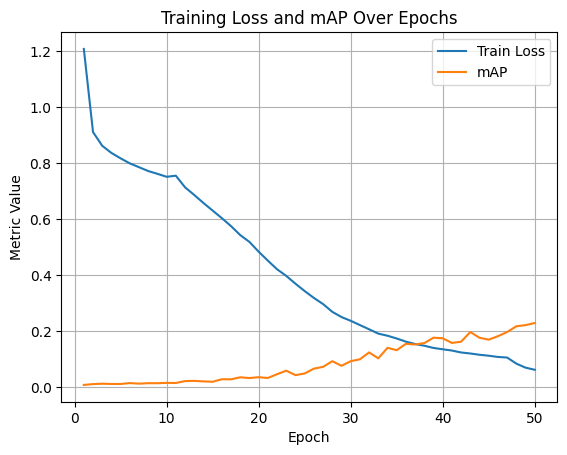

In [ ]:
epochs = list(range(1, len(val_scores) + 1))

plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_scores, label='mAP')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Loss and mAP Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Training Part 2 Detector Model

In [ ]:
detector = retinanet_resnet50_fpn()

num_classes = 2  # pneumonia + background
in_channels = detector.head.classification_head.conv[0][0].in_channels
num_anchors = detector.head.classification_head.num_anchors

detector.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes
)

detector.load_state_dict(torch.load(os.path.join(models_dir, 'best_retinaNet_detector.pth')))

for param in detector.backbone.body.parameters():
  param.requires_grad = True
for param in detector.backbone.fpn.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


In [ ]:
optimizer = optim.SGD([
        {'params': detector.head.parameters(), 'lr': 0.005},
        {'params': detector.backbone.parameters(), 'lr': 0.001},
    ], momentum=0.9, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
num_epochs = 50

detector.to(device)

train_losses = []
val_scores = []

best_score = 0.2287
epoch_no_improve = 0

for epoch in range(num_epochs):
  print('-'*20)
  print(f'Epoch {epoch + 51}/{num_epochs + 50}')
  print('-'*20)

  train_loss = train_one_epoch(detector, train_loader, optimizer, device)
  val_score = evaluate_model(detector, val_loader, device)

  print(f'Train Loss: {train_loss:.4f}')
  print(f'Val Score: {val_score:.4f}')

  scheduler.step(val_score)

  train_losses.append(train_loss)
  val_scores.append(val_score)

  if val_score > best_score:
    best_score = val_score
    torch.save(detector.state_dict(), os.path.join(models_dir, 'best_retinaNet_detector.pth'))
    print('==>Saved best model.')
    epoch_no_improve = 0
  else:
    epoch_no_improve += 1

  if epoch_no_improve >= 7:
    print('==>Early stopping')
    break

--------------------
Epoch 51/100
--------------------
Train Loss: 0.0816
Val Score: 0.2126
--------------------
Epoch 52/100
--------------------
Train Loss: 0.0982
Val Score: 0.2078
--------------------
Epoch 53/100
--------------------
Train Loss: 0.0962
Val Score: 0.2231
--------------------
Epoch 54/100
--------------------
Train Loss: 0.0966
Val Score: 0.2052
--------------------
Epoch 55/100
--------------------
Train Loss: 0.0950
Val Score: 0.2167
--------------------
Epoch 56/100
--------------------
Train Loss: 0.0910
Val Score: 0.2014
--------------------
Epoch 57/100
--------------------
Train Loss: 0.0886
Val Score: 0.2085
==>Early stopping


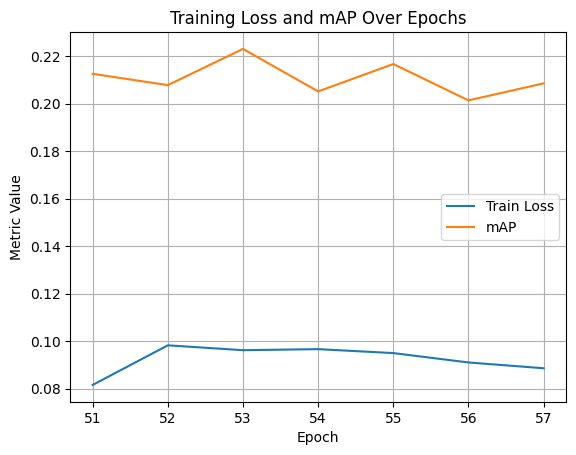

In [ ]:
epochs = list(range(51, len(val_scores) + 51))

plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_scores, label='mAP')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Loss and mAP Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Detecor Loss and mAP

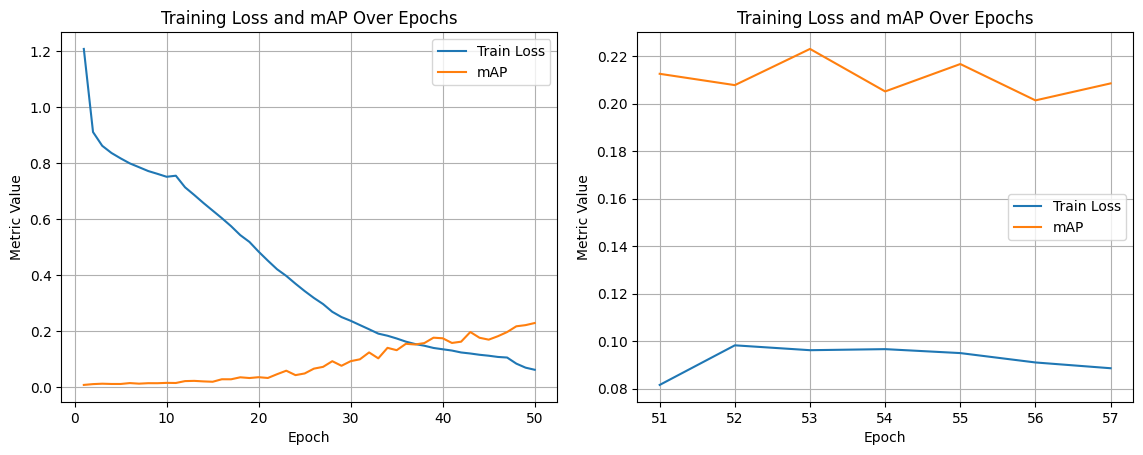


## Training Progress: Loss and mAP Over Epochs

The plots above depict the training progression of the RetinaNet model in terms of **training loss** and **mean Average Precision (mAP)** over 57 epochs.

### Training Phases:
- **Epochs 1–10**: Only the classification head and FPN layers were trained, while the ResNet-50 backbone (`backbone.body`) was kept frozen.
- **After Epoch 10**: The backbone was unfrozen, enabling fine-tuning of the deeper convolutional layers. This resulted in a noticeable acceleration in both loss reduction and mAP improvement.

### Key Observations:
- **Training Loss** decreased consistently from approximately **1.2** to below **0.1**, indicating effective optimization and convergence.
- **mAP** (evaluated using the RSNA-style metric) improved steadily, especially after unfreezing the backbone, reaching over **0.22** by epoch 57.
- Between **epochs 51 and 57**, both loss and mAP stabilized, suggesting the model reached a performance plateau.

These results demonstrate that a two-phase training strategy—starting with frozen backbone layers and followed by full fine-tuning—enables RetinaNet to effectively learn to detect pneumonia regions in chest X-ray images.


## Visualize predicted Bounding Boxes on the Validation set

## Custom Dataset to help with plotting of X-ray images with ground truth and predicte boounding boxes.

In [ ]:
class RSNAVisDataset(Dataset):
  def __init__(self, df, images_dir, transforms=None):
    self.images_dir = images_dir
    self.transforms = transforms

    self.image_ids = df['patientId'].unique()
    self.df = df
    self.annotations = df.groupby('patientId')

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    img_path = os.path.join(self.images_dir, f'{image_id}.jpg')

    image = Image.open(img_path).convert("L")
    if self.transforms:
      image = self.transforms(image)

    records = self.annotations.get_group(image_id)
    boxes = []

    if records['Target'].iloc[0] == 1:
      for _, row in records.iterrows():
        x, y, w, h = row[['x', 'y', 'width', 'height']]
        boxes.append([x, y, x + w, y + h])

    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.ones((len(boxes),), dtype=torch.int64)

    target = {
        'boxes': boxes,
        'labels': labels,
        'filename': image_id
    }

    return image, target

## Visualize result Function

In [ ]:
import matplotlib.patches as patches

def visualize_results(results, indices):
    if not isinstance(indices, list):
        indices = [indices]

    num_images = len(indices)
    cols = min(4, num_images)
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten() if num_images > 1 else [axes]

    for i, index in enumerate(indices):
        result = results[index]
        filename = result['filename']
        gt_boxes = result['gt_boxes']
        pred_boxes = result['pred_boxes']
        pred_scores = result['pred_scores']

        img_path = os.path.join(images_dir, f'{filename}.jpg')
        image = Image.open(img_path).convert("L")

        ax = axes[i]
        ax.imshow(image, cmap='gray')

        # Draw ground truth boxes (green)
        for box in gt_boxes:
            x1, y1, x2, y2 = box
            width, height = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), width, height,
                                     linewidth=2, edgecolor='g', facecolor='none', label='GT')
            ax.add_patch(rect)

        # Draw predicted boxes (red)
        for box, score in zip(pred_boxes, pred_scores):
            if score is not None and score < 0.5:
                continue
            x1, y1, x2, y2 = box
            width, height = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), width, height,
                                     linewidth=1, edgecolor='r', facecolor='none', label='Pred')
            ax.add_patch(rect)
            if score is not None:
                ax.text(x1, y1 - 5, f'Score: {score:.2f}', color='r', fontsize=6, backgroundcolor='white')

        handles, labels = ax.get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        ax.legend(unique.values(), unique.keys(), fontsize=8)
        ax.set_title(f'Image: {filename}')
        ax.axis('off')

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

## Evaluate Model Function

for each filename in `dataloader` it returns the ground truth and predicted bounding box with their confident score and the avaraged precision of the specific image.

In [ ]:
def eval_model(model, dataloader, device):
  model.eval()
  model.to(device)

  all_scores = []
  all_results = []

  with torch.no_grad():
    for images, targets in dataloader:
      images = [img.to(device) for img in images]
      outputs = model(images)

      for output, target in zip(outputs, targets):
        pred_boxes = output['boxes'].detach().cpu().tolist()
        gt_boxes = target['boxes'].detach().cpu().tolist()
        pred_scores = output['scores'].detach().cpu().tolist()

        score = evaluate_image(gt_boxes, pred_boxes)
        all_scores.append(score)
        all_results.append({
            'filename': target['filename'],
            'gt_boxes': gt_boxes,
            'pred_boxes': pred_boxes,
            'pred_scores': pred_scores,
            'score': score
        })

  avg_score = sum(all_scores) / len(all_scores) if all_scores else 0.0
  return avg_score, all_results

In [ ]:
detector = retinanet_resnet50_fpn()

num_classes = 2  # pneumonia + background
in_channels = detector.head.classification_head.conv[0][0].in_channels
num_anchors = detector.head.classification_head.num_anchors

detector.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes
)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


In [ ]:
detector.load_state_dict(torch.load(os.path.join(models_dir, 'best_retinaNet_detector.pth')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {device}')

Using Device: cuda


In [ ]:
def collate_fn(batch):
  return tuple(zip(*batch))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize([0.485]*3, [0.229]*3)
])

val_dataset = RSNAVisDataset(val_df_positives, images_dir, transforms=transform)
test_dataset = RSNAVisDataset(test_df_positives, images_dir, transforms=transform)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

## Qualitative Results on Validation Set

The images below show RetinaNet’s predicted bounding boxes (in **red**) overlaid on ground truth boxes (in **green**) for selected samples from the **validation set**.

- **Confidence scores** are displayed for each predicted box.
- The model shows good alignment with ground truth in many cases, correctly identifying the location and extent of pneumonia.
- Some false positives and partial mismatches are still present, indicating room for further refinement.

The evaluation on the full validation set yielded a **mean Average Precision (mAP)** score of **0.227**, following the RSNA challenge metric. This demonstrates reasonable detection performance given the difficulty of the task and the subtle visual cues in some X-rays.


In [ ]:
mAP, results = eval_model(detector, val_loader, device)
print(f'mAP: {mAP}')

mAP: 0.22681908819596017


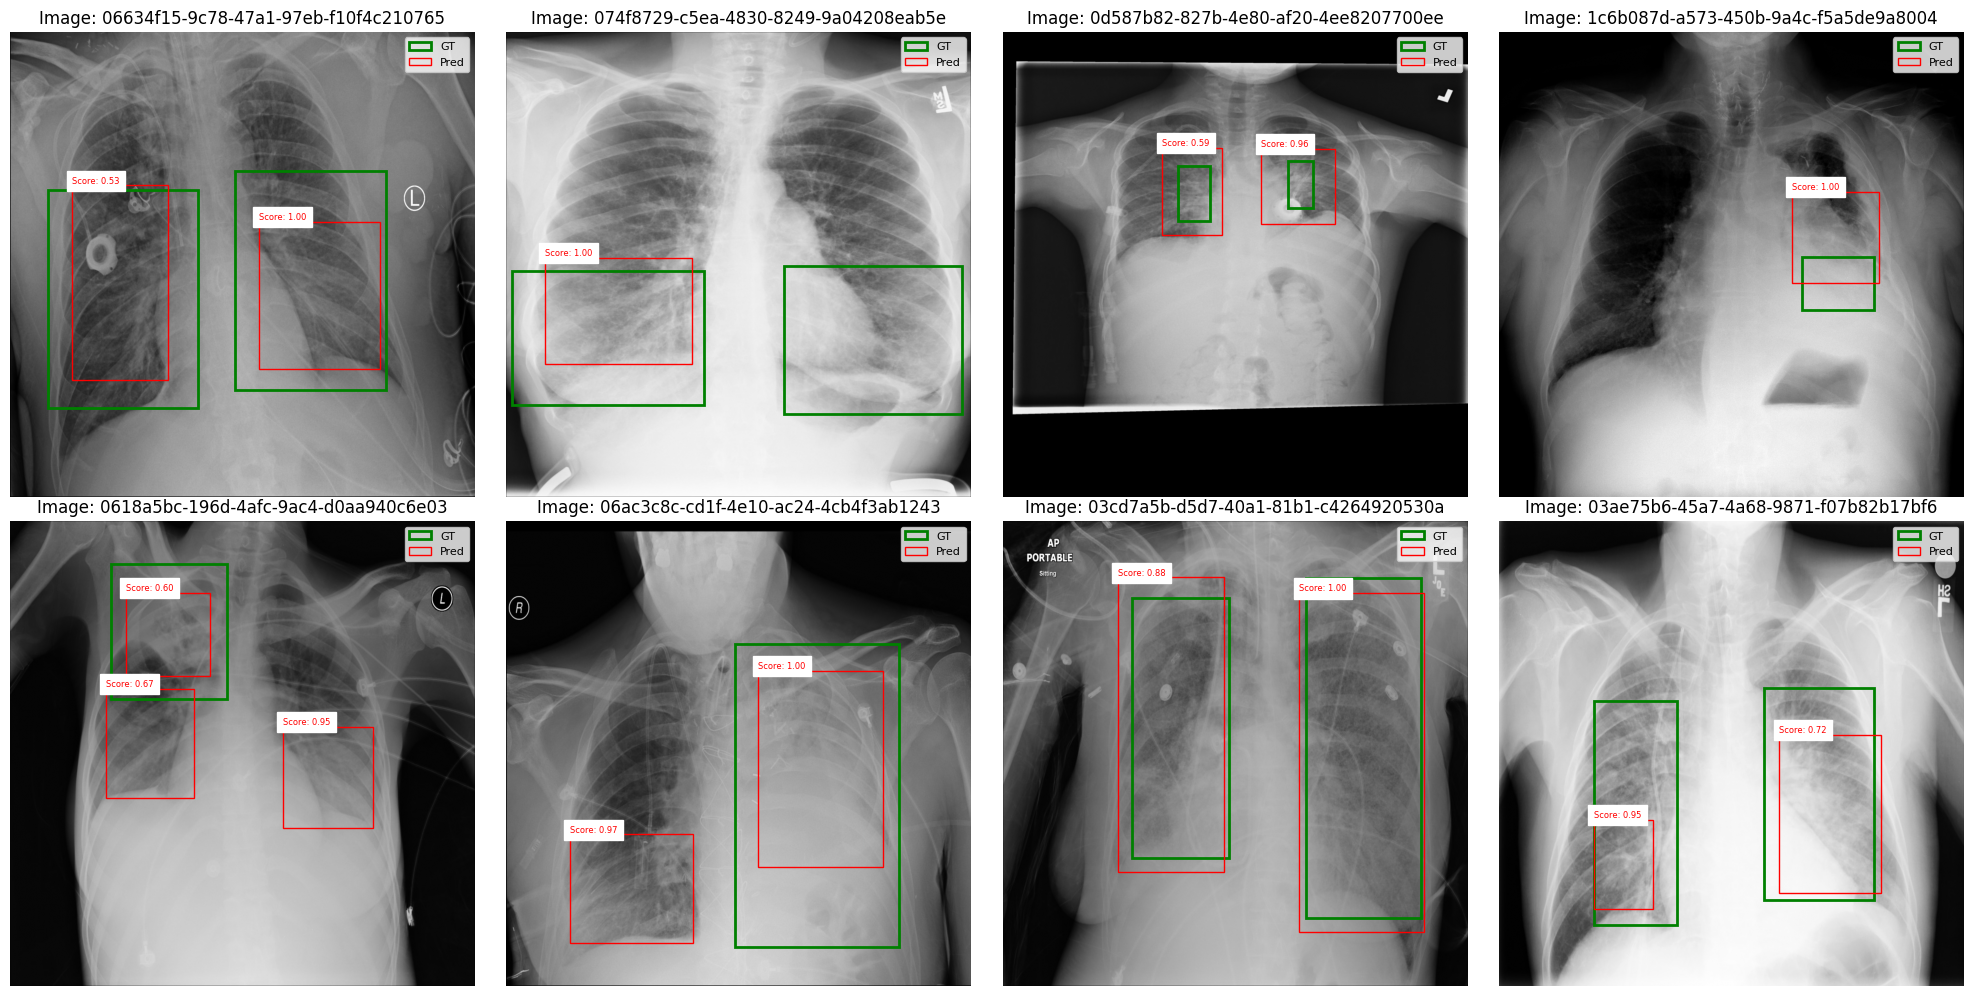

In [ ]:
indices = [5, 10, 25, 50 ,3, 6, 2, 1]
visualize_results(results, indices)

## Qualitative Results on Test Set

The visualizations below show the model’s performance on samples from the **test set**, with:

- **Green boxes** representing ground truth pneumonia regions.
- **Red boxes** representing model predictions, annotated with confidence scores.

The predictions align well with the ground truth in most cases, with high confidence scores (often above 0.95). Some predictions slightly overshoot or undershoot the annotated regions, which may affect the IoU-based evaluation.

The model achieved a **mean Average Precision (mAP)** of **0.228** on the test set (RSNA-style metric), closely matching its validation performance. This consistency suggests that the model generalizes reasonably well to unseen data and is robust in detecting pneumonia in diverse X-ray images.


In [ ]:
mAP, results = eval_model(detector, test_loader, device)
print(f'Test set mAP: {mAP}')

Test set mAP: 0.22773644304946286


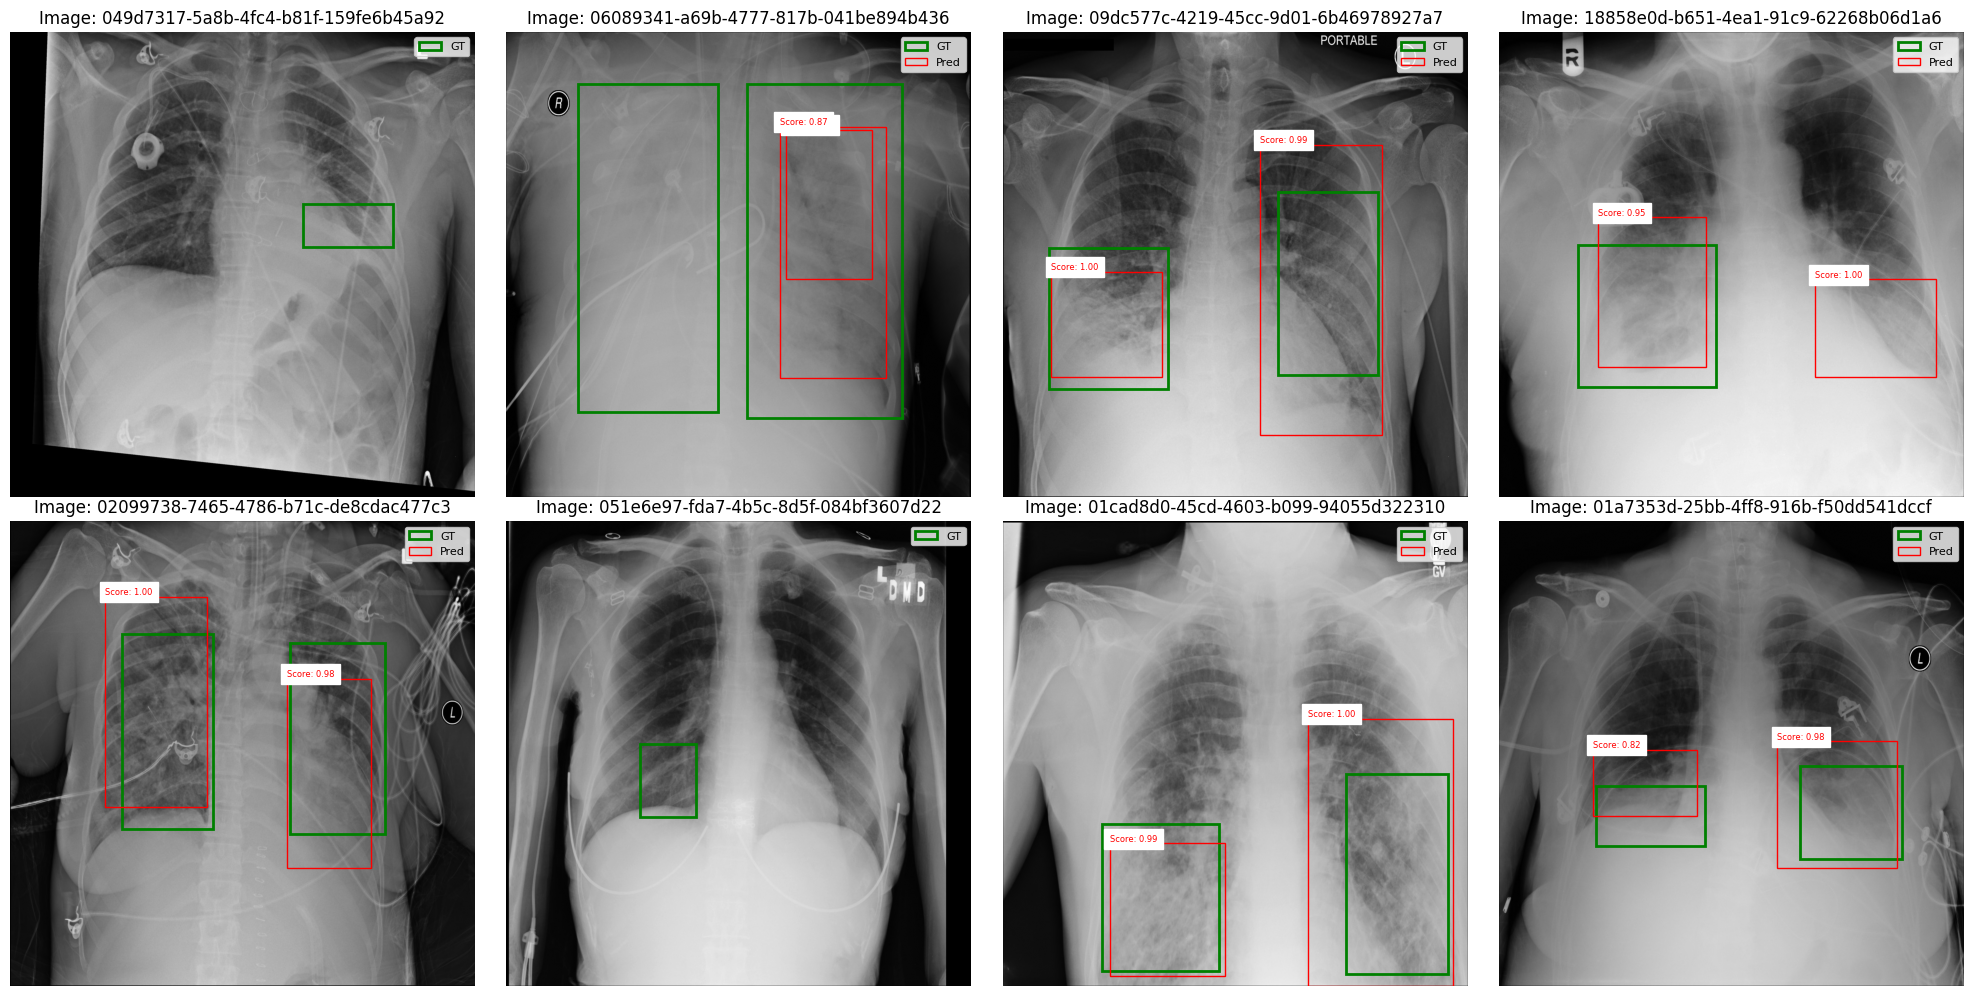

In [ ]:
indices = [5, 10, 25, 50 ,3, 6, 2, 1]
visualize_results(results, indices)

# Final Pipeline

This section presents the complete pneumonia detection pipeline, integrating both classification and object detection components.

The pipeline operates in two sequential stages:

1. **Image-Level Classification**  
   An ensemble classifier first determines whether a chest X-ray image is likely to show signs of pneumonia. Images predicted as normal are immediately classified as such, bypassing further processing.

2. **Region-Level Detection**  
   Images classified as positive are passed to a RetinaNet-based object detector, which localizes pneumonia-affected regions. The detector was trained only on positive samples with bounding box annotations to reduce training time.

   - **Post-detection decision logic**: If the detector does **not predict any bounding boxes**, the image is reclassified as **normal**. Otherwise, it is confirmed as a pneumonia case.

A threshold of **0.45** was applied to the classifier’s pneumonia probability output to improve recall, minimizing the likelihood of false negatives.

This two-stage design ensures diagnostic accuracy while maintaining computational efficiency, making it suitable for real-world medical deployment.


## Get models Funcitons

In [ ]:
def get_effnet_model():
  effnet = torchvision.models.efficientnet_b4()

  effnet.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
  )
  effnet.load_state_dict(torch.load(os.path.join(models_dir, 'best_efficentnet.pth')))
  return effnet

In [ ]:
def get_vgg_model():
  vgg = torchvision.models.vgg16()

  vgg.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(1024, 2)  # Binary classification (Normal, Pneumonia)
)
  vgg.load_state_dict(torch.load(os.path.join(models_dir, 'best_vgg.pth')))

  return vgg

In [ ]:
def get_densenet_model():
  densenet = torchvision.models.densenet121()

  densenet.classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(512, 2)
  )
  densenet.load_state_dict(torch.load(os.path.join(models_dir, 'best_densenet.pth')))

  return densenet

In [ ]:
def get_retina_model():
  detector = retinanet_resnet50_fpn()

  num_classes = 2  # pneumonia + background
  in_channels = detector.head.classification_head.conv[0][0].in_channels
  num_anchors = detector.head.classification_head.num_anchors

  detector.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes
  )
  detector.load_state_dict(torch.load(os.path.join(models_dir, 'best_retinaNet_detector.pth')))

  return detector

## Dataset class, Transformaers and DataLoader

In [ ]:
patient_labels= df.groupby('patientId')['Target'].max().reset_index()

train_ids, temp_ids = train_test_split(patient_labels, test_size=0.2, random_state=42, stratify=patient_labels['Target'])
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42, stratify=temp_ids['Target'])

train_df = df[df['patientId'].isin(train_ids['patientId'])]
val_df = df[df['patientId'].isin(val_ids['patientId'])]
test_df = df[df['patientId'].isin(test_ids['patientId'])]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {device}')

Using Device: cuda


In [ ]:
class RSNADataset(Dataset):
  def __init__(self, df, images_dir, transforms=None):
    self.images_dir = images_dir
    self.transforms = transforms

    self.image_ids = df['patientId'].unique()
    self.df = df
    self.annotations = df.groupby('patientId')

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    img_path = os.path.join(self.images_dir, f'{image_id}.jpg')

    image = Image.open(img_path).convert("L")
    if self.transforms:
      image = self.transforms(image)

    records = self.annotations.get_group(image_id)
    boxes = []

    if records['Target'].iloc[0] == 1:
      for _, row in records.iterrows():
        x, y, w, h = row[['x', 'y', 'width', 'height']]
        boxes.append([x, y, x + w, y + h])

    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.ones((len(boxes),), dtype=torch.int64)

    target = {
        'boxes': boxes,
        'labels': labels,
        'filename': image_id
    }

    return image, target

In [ ]:
classifier_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def collate_fn(batch):
  return tuple(zip(*batch))

detector_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize([0.485]*3, [0.229]*3)
])

In [ ]:
val_dataset = RSNADataset(val_df, images_dir, transforms=classifier_transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_dataset = RSNADataset(test_df, images_dir, transforms=classifier_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Pipeline creation

In [ ]:
class PneumoniaPipeline:
  def __init__(self, classifier_models, classifier_weights, detector_model, device, detector_threshold=0.5):
    self.models = classifier_models
    self.weights = classifier_weights
    self.detector = detector_model
    self.device = device
    self.detector_threshold = detector_threshold

    # set models to eval mode and move to device
    for model in self.models.values():
      model.eval()
      model.to(self.device)

    self.detector.eval()
    self.detector.to(device)

  def ensemble_predict(self, image_tensor, threshold=0.5):
    image_tensor = image_tensor.unsqueeze(0).to(self.device)
    probs = []

    for name, model in self.models.items():
      with torch.no_grad():
        output = model(image_tensor)
        prob = F.softmax(output, dim=1)[0]
        probs.append(prob * self.weights[name])

    final_prob = sum(probs)
    p_pneumonia = final_prob[1].item()
    predicted_class = 1 if p_pneumonia >= threshold else 0
    confidence = final_prob[predicted_class].item()


    return predicted_class, confidence, p_pneumonia

  def detect_boxes(self, image_tensor):
    image_tensor = image_tensor.unsqueeze(0).to(self.device)
    with torch.no_grad():
      outputs = self.detector(image_tensor)

    boxes = outputs[0]['boxes'].detach().cpu().tolist()
    scores = outputs[0]['scores'].detach().cpu().tolist()
    filtered_boxes = [box for box, score in zip(boxes, scores) if score >= self.detector_threshold]

    return filtered_boxes

In [ ]:
def load_image_detector(image_id):
  image_path = os.path.join(images_dir, f'{image_id}.jpg')
  image = Image.open(image_path).convert("L")
  image_tensor = detector_transform(image)
  return image_tensor

In [ ]:
weights = {
    'effnet': 0.32609051,
    'vgg': 0.34048762,
    'densenet': 0.33342187
}

effnet = get_effnet_model()
vgg = get_vgg_model()
densenet = get_densenet_model()
detector = get_retina_model()
models = {
    'effnet': effnet,
    'vgg': vgg,
    'densenet': densenet
}

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


In [ ]:
pipeline = PneumoniaPipeline(models, weights, detector, device, detector_threshold=0.45)

## Setup pipeline evaluation

In [ ]:
def evaluate_image(gt_boxes, pred_boxes):
    thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

    # Handle special case: no ground truth boxes
    if len(gt_boxes) == 0:
        return 1.0 if len(pred_boxes) == 0 else 0.0
    if len(pred_boxes) == 0 and len(gt_boxes) > 0:
      return 0
    gt = gt_boxes.clone().detach().float().reshape(-1, 4)
    pred = torch.tensor(pred_boxes, dtype=torch.float32).reshape(-1, 4)

    iou_matrix = box_iou(gt, pred)
    precisions = []

    for t in thresholds:
        matched_gt = set()
        matched_pred = set()

        pairs = (iou_matrix > t).nonzero(as_tuple=False)
        iou_above_thresh = iou_matrix[pairs[:, 0], pairs[:, 1]]
        sorted_indices = torch.argsort(iou_above_thresh, descending=True)
        pairs = pairs[sorted_indices]

        for gt_idx, pred_idx in pairs:
            gt_i = gt_idx.item()
            pred_i = pred_idx.item()
            if gt_i in matched_gt or pred_i in matched_pred:
                continue
            matched_gt.add(gt_i)
            matched_pred.add(pred_i)

        TP = len(matched_gt)
        FP = len(pred) - TP
        FN = len(gt) - TP

        precision = TP / (TP + FP + FN)
        precisions.append(precision)

    return sum(precisions) / len(precisions)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    auc
)
def plot_metrics(results):
  # Prepare data
  results_df = pd.DataFrame(results)
  y_true = results_df['actual']
  y_pred = results_df['pred_class']
  y_scores = results_df['p_pneumonia']

  # Metrics
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  metrics = [acc, prec, rec, f1]
  metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

  # ROC
  fpr, tpr, _ = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)

  # Confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  labels = ['Normal', 'Pneumonia']

  # Create subplot layout
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))

  # Confusion Matrix
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
  axes[0].set_title('Confusion Matrix')
  axes[0].set_xlabel('Predicted Label')
  axes[0].set_ylabel('True Label')

  # ROC Curve
  axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
  axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
  axes[1].set_xlim([0.0, 1.0])
  axes[1].set_ylim([0.0, 1.05])
  axes[1].set_xlabel('False Positive Rate')
  axes[1].set_ylabel('True Positive Rate')
  axes[1].set_title('ROC Curve')
  axes[1].legend(loc="lower right")

  # Classification Metrics Bar Chart
  axes[2].bar(metric_labels, metrics, color='steelblue')
  axes[2].set_ylim(0, 1.05)
  axes[2].set_ylabel('Score')
  axes[2].set_title('Classification Metrics')
  for i, v in enumerate(metrics):
      axes[2].text(i, v + 0.02, f"{v:.2f}", ha='center')

  plt.tight_layout()
  plt.show()

In [ ]:
def evaluate_pipeline(pipeline, dataloader):
  results = []
  scores = []

  for image, targets in dataloader:
    image_id = targets['filename'][0]
    image_tensor = image[0]
    pred_class, confidence, p_pneumonia = pipeline.ensemble_predict(image_tensor, threshold=0.45)

    pred_boxes = []
    if pred_class == 1:
      image_detector = load_image_detector(image_id)
      pred_boxes = pipeline.detect_boxes(image_detector)
      score = evaluate_image(targets['boxes'], pred_boxes)
      scores.append(score)

      if len(pred_boxes) == 0:
        pred_class = 0
        confidence = 0
        p_pneumonia = 0

    actual_class = 1 if len(targets['boxes'][0]) > 0 else 0
    if actual_class == 1 and len(pred_boxes) == 0:
      scores.append(0.0)

    results.append({
        'filename': image_id,
        'pred_class': pred_class,
        'confidence': confidence,
        'p_pneumonia': p_pneumonia,
        'actual': actual_class,
        'pred_boxes': pred_boxes,
        'gt_boxes': targets['boxes'][0]
    })

  plot_metrics(results)

  score = sum(scores) / len(scores) if scores else 0.0
  print(f'mAP: {score}')

  return results

## Model Performance Evaluation and Threshold Analysis

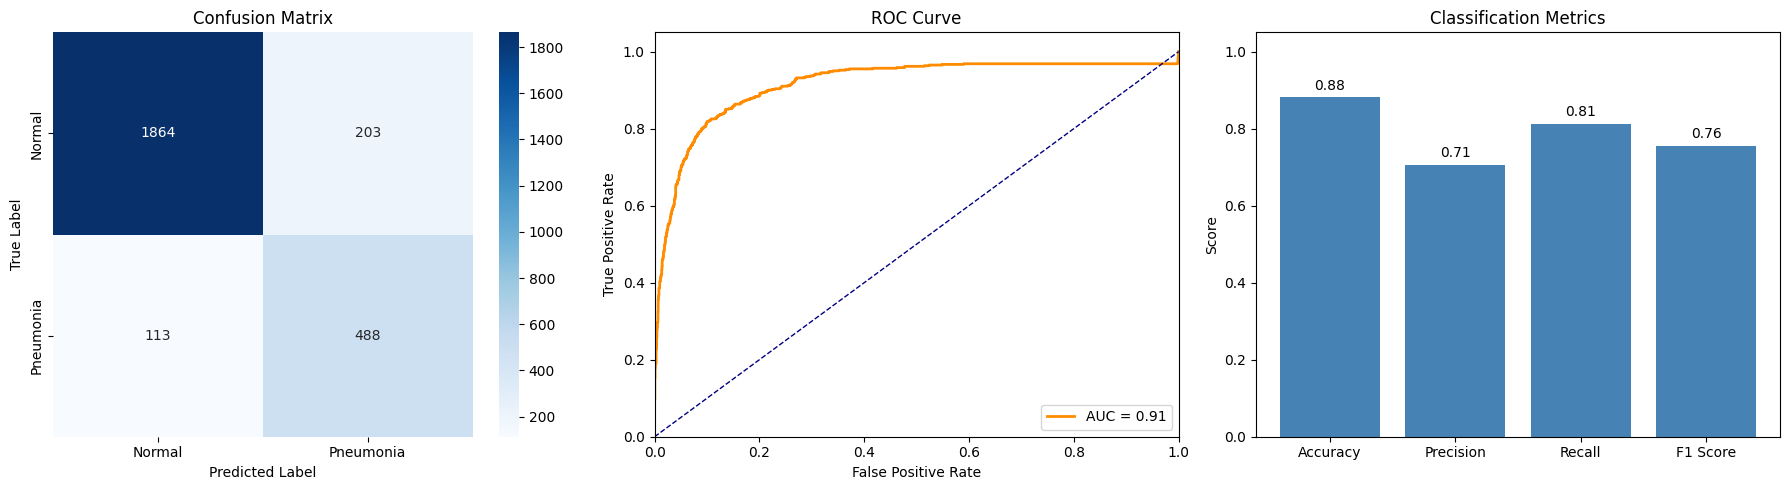

mAP: 0.2205846576841136


In [ ]:
val_results = evaluate_pipeline(pipeline, val_loader)

Validation Performance

The final two-stage pipeline was evaluated on the validation set, and the results are summarized below.

Classification Performance:
- **Accuracy**: 0.88
- **Precision**: 0.71
- **Recall**: 0.81
- **F1 Score**: 0.76
- **AUC (Area Under ROC Curve)**: 0.91

The confusion matrix indicates that the model achieves a strong balance between sensitivity and specificity, correctly identifying the majority of pneumonia cases while maintaining a low false positive rate.

Detection Performance:
- **Mean Average Precision (mAP)**: 0.22

This mAP score, computed using the RSNA-style evaluation metric across IoU thresholds from 0.4 to 0.75, reflects the model's localization capability on pneumonia-positive cases. While moderate, this score demonstrates the model’s ability to detect affected regions in a consistent and interpretable manner.

Together, these results highlight the pipeline’s effectiveness in both classifying and localizing pneumonia from chest X-ray images in a clinically meaningful way.


In [ ]:
from sklearn.metrics import classification_report

val_results_df = pd.DataFrame(val_results)

y_true = val_results_df['actual']
y_scores = val_results_df['p_pneumonia']

for thresh in [0.35, 0.4, 0.42, 0.45, 0.5]:
    print(f"\nThreshold = {thresh}")
    y_pred_thresh = (y_scores >= thresh).astype(int)
    print(classification_report(y_true, y_pred_thresh, target_names=["Normal", "Pneumonia"]))


Threshold = 0.35
              precision    recall  f1-score   support

      Normal       0.96      0.82      0.88      2067
   Pneumonia       0.59      0.88      0.70       601

    accuracy                           0.83      2668
   macro avg       0.77      0.85      0.79      2668
weighted avg       0.87      0.83      0.84      2668


Threshold = 0.4
              precision    recall  f1-score   support

      Normal       0.95      0.87      0.91      2067
   Pneumonia       0.65      0.84      0.73       601

    accuracy                           0.86      2668
   macro avg       0.80      0.85      0.82      2668
weighted avg       0.88      0.86      0.87      2668


Threshold = 0.42
              precision    recall  f1-score   support

      Normal       0.95      0.88      0.91      2067
   Pneumonia       0.67      0.83      0.74       601

    accuracy                           0.87      2668
   macro avg       0.81      0.86      0.83      2668
weighted avg       0.

Threshold Evaluation Summary

| Threshold | Precision (Pneumonia) | Recall (Pneumonia) | F1-score (Pneumonia) | Accuracy |
| --------- | --------------------- | ------------------ | -------------------- | -------- |
| **0.35**  | 0.59                  | **0.88**           | 0.70                 | 0.83     |
| **0.40**  | 0.65                  | 0.84               | 0.73                 | 0.86     |
| **0.42**  | 0.67                  | 0.83               | 0.74                 | 0.87     |
| **0.45**  | 0.71                  | 0.81               | 0.76                 | 0.88     |
| **0.50**  | **0.75**              | 0.77               | **0.76**             | **0.89** |

#### Recall vs. Precision Trade-off

- Lower thresholds (e.g., **0.35**) prioritize **recall** (catching more pneumonia cases), but at the cost of lower **precision** (more false positives).
- Higher thresholds (e.g., **0.50**) improve **precision** but slightly lower **recall**.

#### Best Overall Balance

- **Threshold = 0.45** and **0.50** both give strong performance:
  - At **0.45**: Higher **recall** (0.81) and solid **precision** (0.71).
  - At **0.50**: Better **precision** (0.75), slightly lower **recall** (0.77), highest **accuracy** (0.89).


We prioritize achieving higher **recall** while maintaining a solid level of **precision** in this task, as it is more critical to identify as many pneumonia cases as possible, even at the cost of some false positives. Therefore, we selected a **threshold of 0.45**, which provides a good balance between recall (0.81) and precision (0.71).


## Final results on the Test set

In [ ]:
import matplotlib.patches as patches

def plot_predictions(results, images_dir, num_samples=5):
  class_names = {0: 'Normal', 1: 'Pneumonia'}

  samples = random.sample(results, num_samples)

  fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 5, 6))

  for ax, res in zip(axes, samples):
    patient_id = res['filename']
    image_path = os.path.join(images_dir, f'{patient_id}.jpg')
    image = Image.open(image_path).convert("L")

    ax.imshow(image, cmap='gray')
    ax.set_title(f"Pred: {class_names[res['pred_class']]}, Confidence: {res['confidence']:.2f}\n GT: {class_names[res['actual']]}")

    # predicted boxes (red)
    for box in res['pred_boxes']:
      x1, y1, x2, y2 = box
      rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                linewidth=2, edgecolor='r', facecolor='none')
      ax.add_patch(rect)

    # ground truth boxes (green)
    for box in res['gt_boxes']:
      x1, y1, x2, y2 = box
      rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                linewidth=2, edgecolor='g', facecolor='none')
      ax.add_patch(rect)

    ax.axis('off')

  handles = [
        patches.Patch(edgecolor='r', facecolor='none', linewidth=2, label='Predicted', linestyle='solid'),
        patches.Patch(edgecolor='g', facecolor='none', linewidth=2, label='Ground Truth', linestyle='solid')
    ]
  axes[-1].legend(handles=handles, loc='lower right')
  plt.tight_layout()
  plt.show()

Number of images in test set: 2669


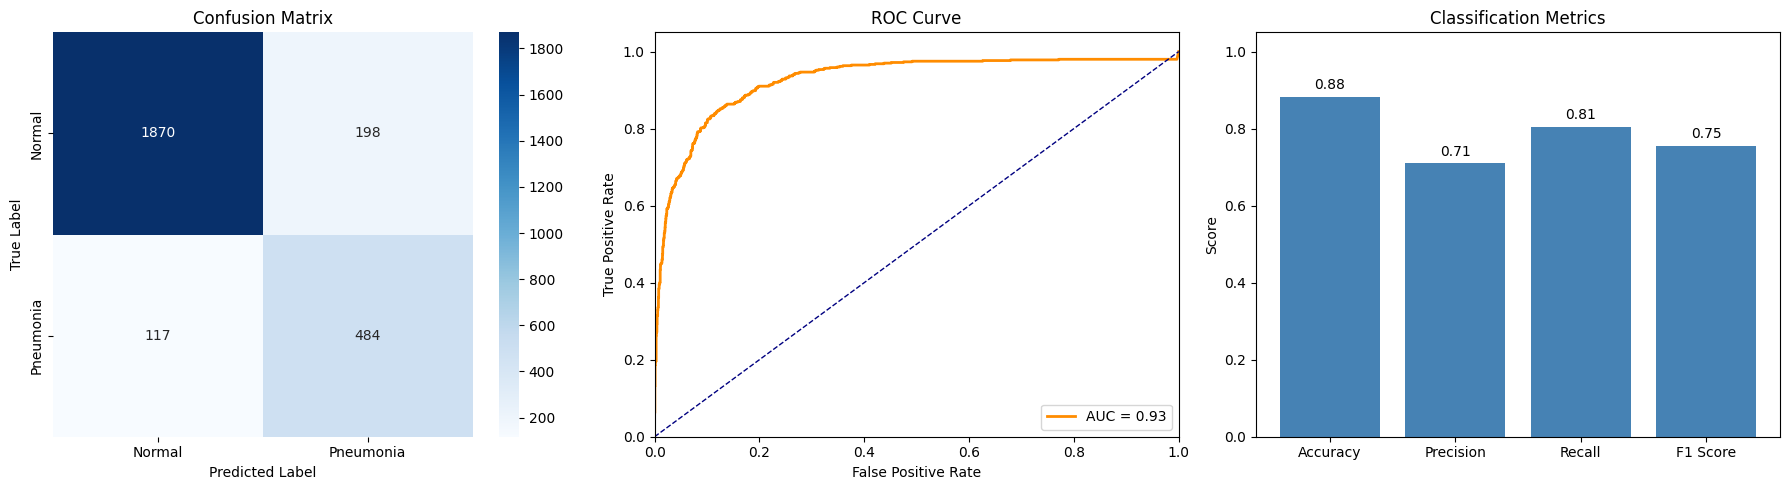

mAP: 0.21464209308417728


In [ ]:
print(f'Number of images in test set: {len(test_loader)}')
results = evaluate_pipeline(pipeline, test_loader)

**Test Set Performance:**

The final pipeline was evaluated on the held-out test set with the following results:

- **Accuracy**: 0.88
- **Precision**: 0.71
- **Recall**: 0.81
- **F1 Score**: 0.75
- **AUC**: 0.93
- **mAP**: 0.21

These results confirm that the pipeline maintains strong classification and localization performance on unseen data, demonstrating its generalizability and clinical applicability.


Bellow we can see samples of True postives, False posticves and false negatives.

In [ ]:
tp_results = [res for res in results if res['pred_class'] == 1 and res['actual'] == 1]
fp_results = [res for res in results if res['pred_class'] == 1 and res['actual'] == 0]
fn_results = [res for res in results if res['pred_class'] == 0 and res['actual'] == 1]

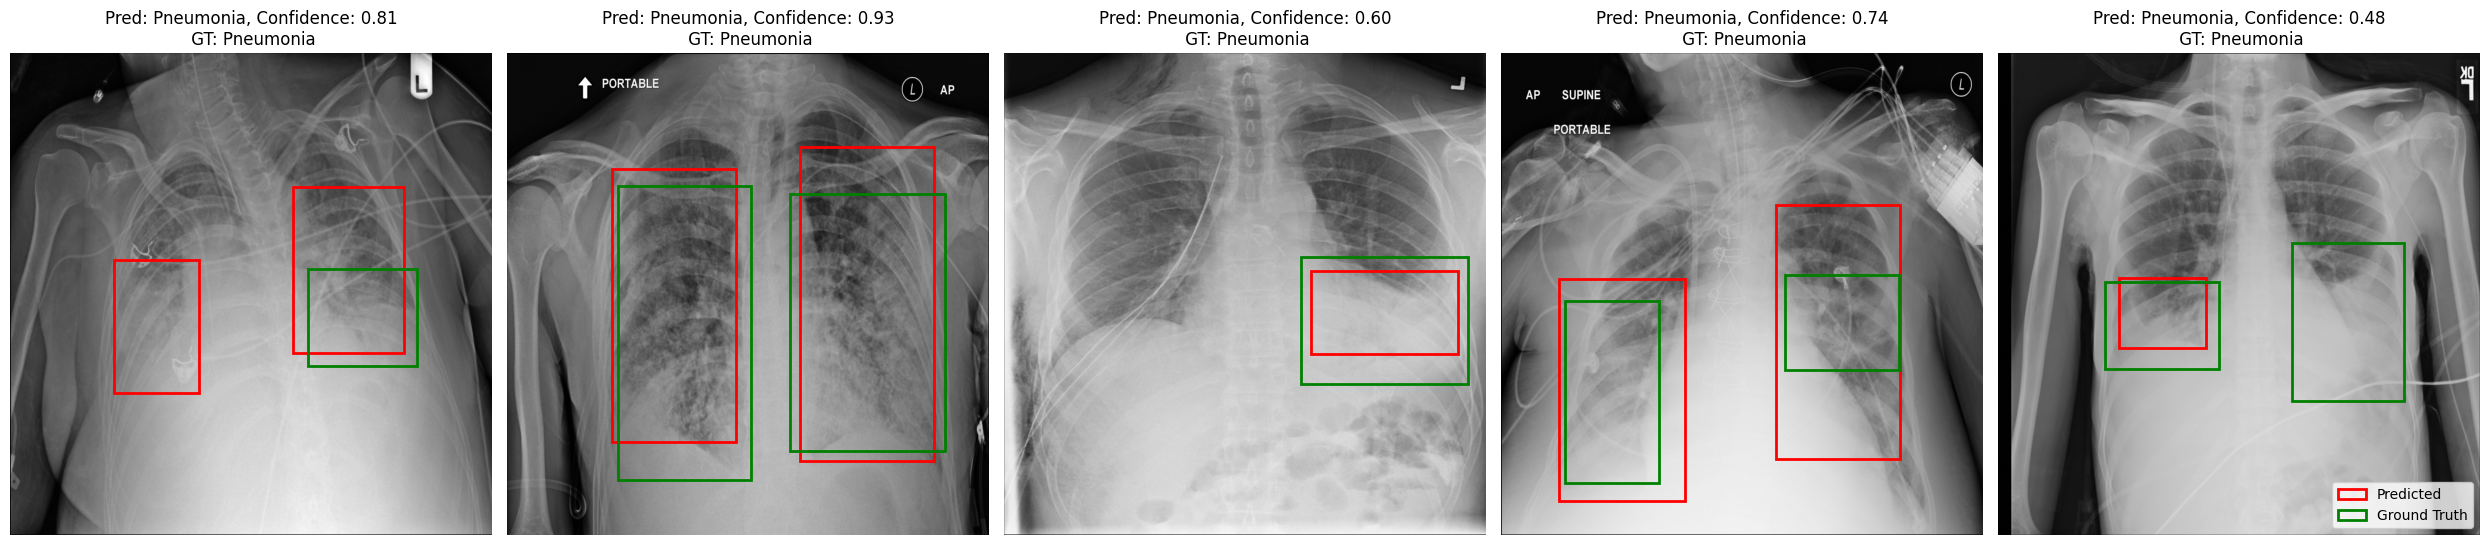

In [ ]:
plot_predictions(tp_results, images_dir)

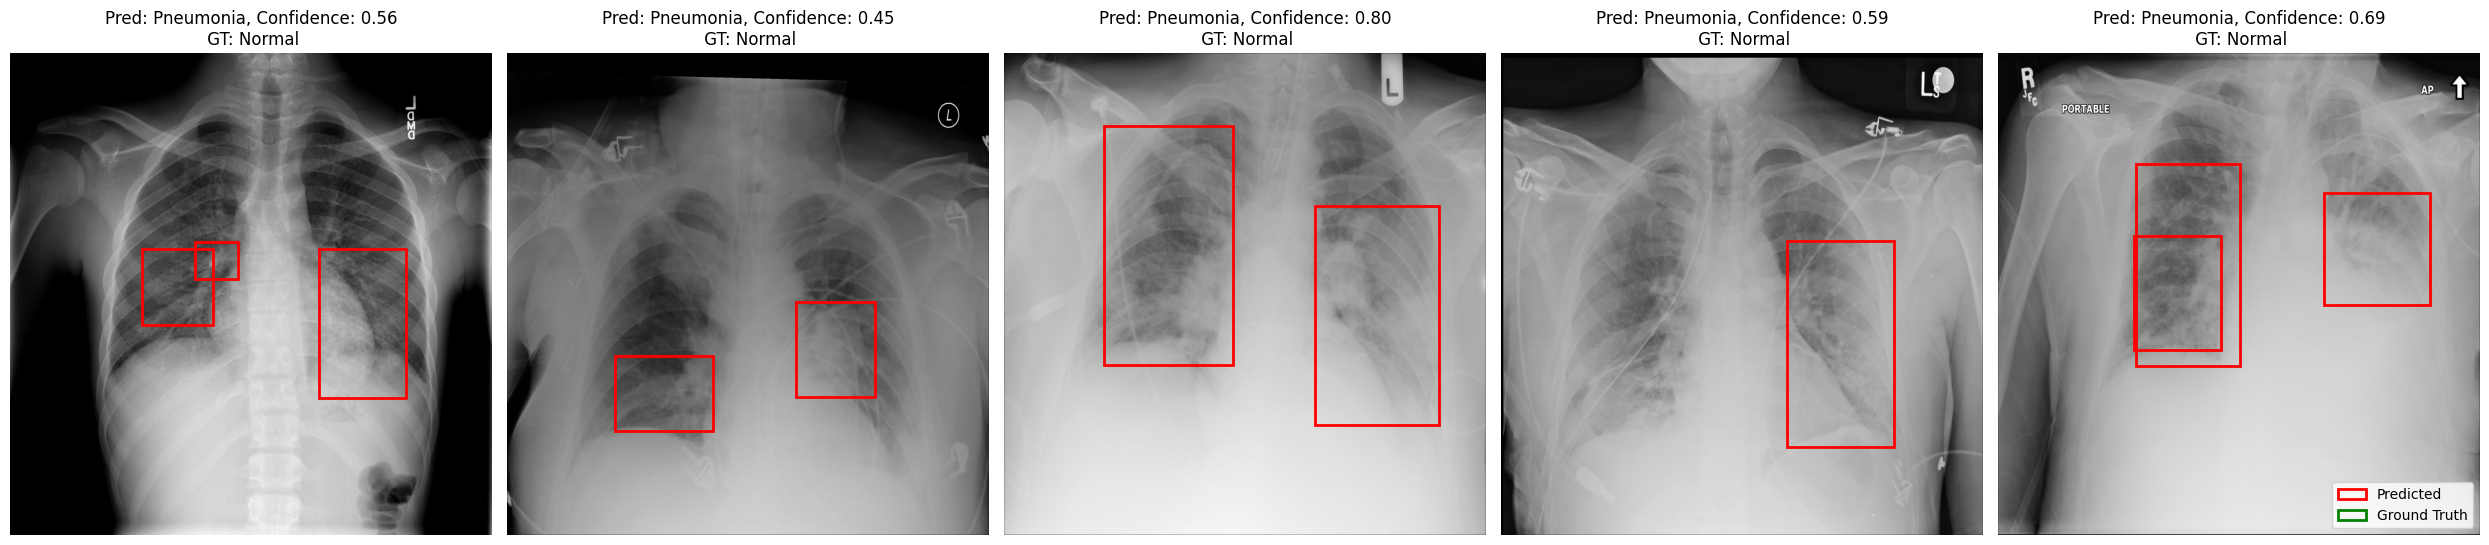

In [ ]:
plot_predictions(fp_results, images_dir)

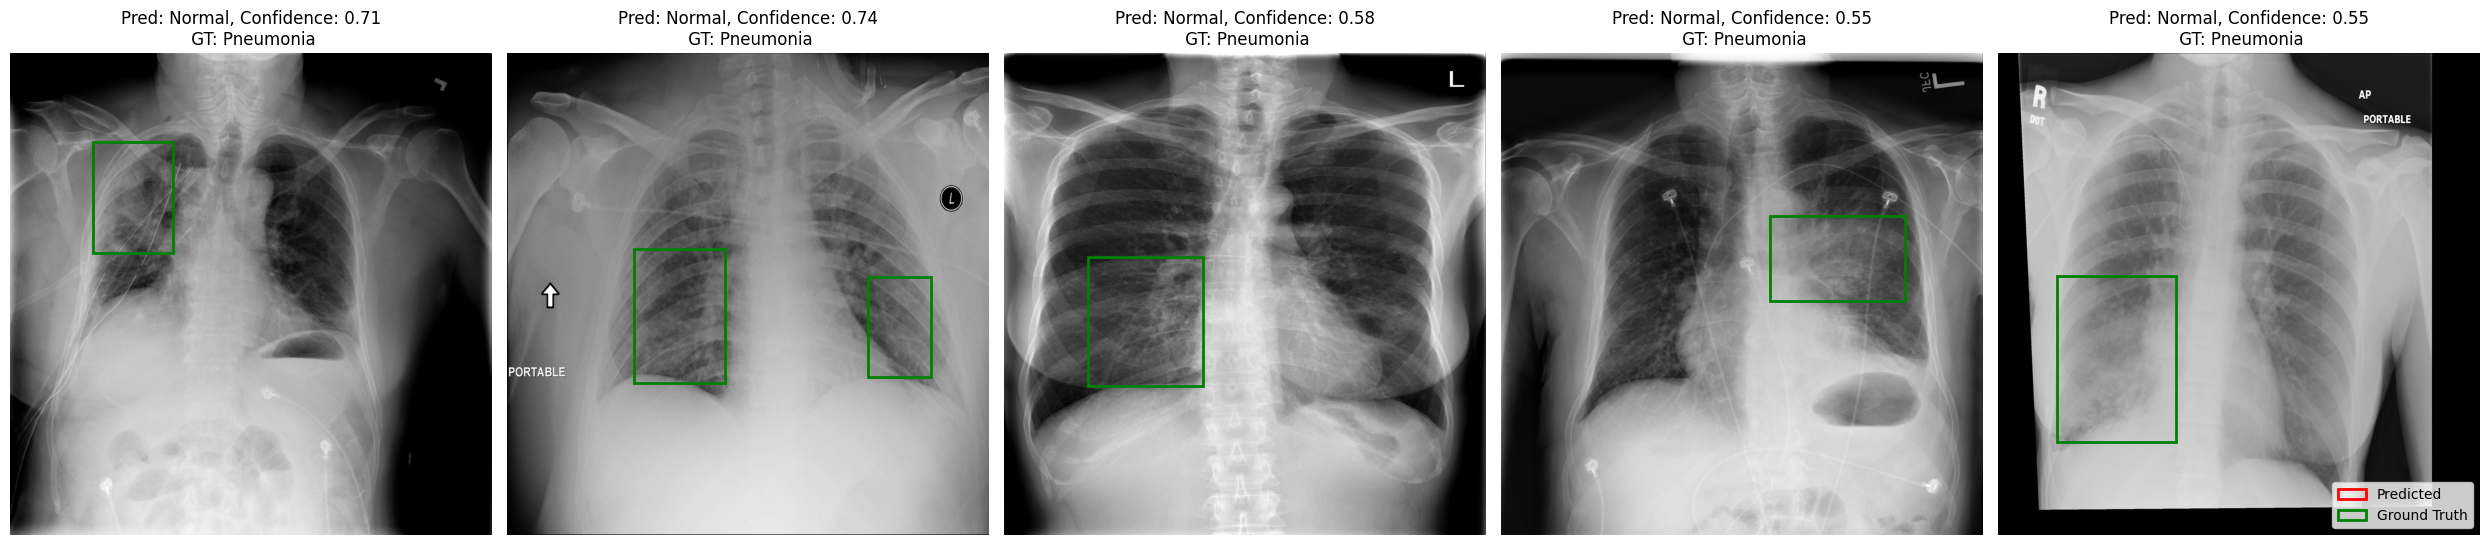

In [ ]:
plot_predictions(fn_results, images_dir)

# Conclusion

In this project, we developed a two-stage deep learning pipeline for detecting pneumonia in chest X-ray images. The first stage involved an image-level classifier composed of an ensemble of three CNN architectures. The second stage utilized a RetinaNet-based object detector trained on positive cases to localize pneumonia regions.

Key outcomes include:
- **AUC of 0.93** and **F1 score of 0.75** on the test set, reflecting strong classification performance.
- **mAP of 0.2146** for region-level detection, evaluated using the RSNA-style multi-threshold metric.

According to the original RSNA Pneumonia Detection Challenge leaderboard, this mAP score would place the model approximately **24th out of 340 participants**, with the 1st place score around **0.25**. This result demonstrates the pipeline’s competitive performance on a challenging medical imaging task.

The two-stage design ensures that the model balances **diagnostic accuracy** and **interpretability**, with a particular emphasis on **minimizing false negatives**—a critical factor in clinical settings.

Future improvements could explore better localization techniques, uncertainty quantification, or post-processing resizing on the predicted bounding boxes.
